In [1]:
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora, models
import re

# Sample text data
sample_text_documents = [
    'طرح استفساریه ماده (24) قانون بیمه مصوب 7/2/1316', 'طرح تسری قانون فوق العاده خاص کارمندان سازمان های پزشکی قانونی کشور و انتقال خون ایران به کارمندان دامپزشکی کشور', 'طرح اصلاح تبصره (2) ماده (39) قانون نظام جامع خدمات رسانی به ایثارگران', 'طرح استفساریه در خصوص تبصره (1) ماده واحده الحاقی صندوق بیمه اجتماعی روستائیان و عشایر به فهرست نهادها و موسسات عمومی دولتی', 'طرح الحاق یک تبصره به قانون واگذاری دوهزار هکتار از منابع ملی شده اطراف چابهار به شهرداری چابهار', 'طرح استفساریه ماده 81 قانون مالیات های مستقیم مصوب 3/12/1366  و اصلاحات بعدی آن', 'طرح اصلاح تبصره (1) ماده (5) قانون حمایت از شرکت ها و موسسات دانش بنیان و تجاری سازی نوآوری ها و اختراعات', 'طرح الحاق یک تبصره به ماده (64) قانون مالیاتهای مستقیم مصوب 1366 و اصلاحات بعدی آن', 'طرح اصلاح قانون بیمه اجتماعی رانندگان حمل و نقل بار و مسافر بین شهری', 'طرح صیانت از حریم عفاف و حجاب', 'طرح اصلاح قانون الحاق سه تبصره به بند (12) ماده (4) قانون نیروی انتظامی جمهوری اسلامی ایران', 'طرح تعیین تکلیف استخدامی معلمین حق التدریسی و آموزشیاران نهضت سوادآموزی در وزارت آموزش و پرورش', 'طرح الحاق یک تبصره به قانون حالت اشتغال مستخدمین شهید، جانباز از کار افتاده و مفقودالاثر انقلاب اسلامی و جنگ تحمیلی مصوب 1372 و اصلاحیه بعدی آن', 'طرح اصلاح ماده (60) آئین نامه داخلی مجلس شورای اسلامی', 'طرح اصلاح قانون تأسیس سازمان نظام مهندسی کشاورزی و منابع طبیعی جمهوری اسلامی ایران', 'طرح تاسیس کارگروههای مشورتی مجلس در استان ها', ' طرح اصلاح ماده (186) قانون آیین نامه داخلی مجلس شورای اسلامی', 'طرح اصلاح ماده (43) قانون حمایت خانواده ', 'طرح اصلاح موادی از آیین نامه داخلی مجلس شورای اسلامی (نحوه رسیدگی به طرح ها و لوایح قانونی)', 'طرح اصلاح قانون تعیین تکلیف تابعیت فرزندان حاصل از ازدواج زنان ایرانی با مردان خارجی مصوب 1385', 'طرح اعلام نسخ قوانین با موضوع انرژی (انرژی اتمی- برق)', 'طرح اصلاح ردیف (1) جزء «ع» بند (3) ماده واحده قانون بودجه سال 1389 کل کشور', 'طرح بهینه سازی مصرف آب شرب', 'طرح تبدیل وضعیت مربیان حق التدریس سازمان آموزش فنی و حرفه ای کشور به رسمی و پیمانی', 'طرح حفظ ، حمایت، توسعه و بهره برداری از منابع دامی کشور', 'طرح الحاق دوتبصره به بند 14 ماده 4 قانون نیروی انتظامی جمهوری اسلامی ایران', 'طرح خدمات رسانی به ایثارگران', 'طرح تعیین تکلیف بیمه اعضاء موسسه صندوق حمایت و بازنشستگی آینده ساز و تحت پوشش قرار گرفتن آنان توسط سازمان تامین اجتماعی', 'طرح الحاق یک تبصره به ماده (5) قانون آیین  نامه داخلی مجلس شورای اسلامی', 'طرح تشکیل ستاد و دبیرخانه دائمی تحقق اهداف نامگذاری سالانه', 'طرح احتساب سابقه تدریس معلمان حق التدریس استخدامی در آموزش و پرورش', 'طرح الحاق یک تبصره به ماده (106) قانون مدیریت خدمات کشوری', 'طرح اصلاح مواد (35) و (55) قانون انتخابات ریاست جمهوری اسلامی ایران مصوب 05/04/1364 و اصلاحات بعدی آن', 'طرح استفساریه جزء (الف) بند «7» ماده واحده قانون بودجه سال 1389 کل کشور', 'طرح اصلاح مواد (213) و (216) آیین نامه داخلی مجلس شورای اسلامی', 'طرح حراستها', 'طرح نحوه تسعیر دارایی ها و بدهی های ارزی بانک مرکزی جمهوری اسلامی ایران در سال 1392 و مصرف سود حاصل از آن', 'طرح شفافیت دریافتی مدیران کشور و استرداد دریافتی های مازاد', 'طرح مبارزه با تبعیض نژادی، تنفر قومی و مذهبی', 'طرح اعلام نسخ قوانین با موضوع ثبت اسناد و املاک', 'طرح ساماندهی اتباع بیگانه', ' طرح تمدید مهلت جذب اعتبارات پروژه های تملک دارایی های سرمایه ای قانون بودجه سال 1392 کل کشور', 'طرح الحاق یک تبصره به ماده «33» و یک تبصره به ماده «193» آیین نامه داخلی مجلس شورای اسلامی', 'طرح الحاق یک تبصره به ماده (206) آیین نامه داخلی مجلس شورای اسلامی', 'طرح اصلاح برخی مواد مربوط به قوانین تعزیرات حکومتی', 'طرح اصلاح جزء «ب» بند 9 قانون بودجه سال 1389 کل کشور', 'طرح الحاق یک تبصره به قانون نحوه اجرای اصول (85) و (138) قانون اساسی جمهوری اسلامی ایران در رابطه با مسئولیتهای رئیس مجلس شورای اسلامی مصوب 1368 و اصلاحات بعدی آن', 'طرح الحاق یک تبصره به بند (1) ماده (68) قانون مدیریت خدمات کشوری', 'طرح استفساریه قانون پولی و بانکی و ماده (39)', 'طرح الزام تحویل تصاویر صورتجلسات شمارش آراء به نامزدهای نمایندگی مجلس شورای اسلامی', 'طرح تاسیس سازمان های استانی توسعه عمران دریا و سواحل', 'طرح سپرده ارزی در بانک های عامل', ' طرح الحاق یک بند به عنوان بند (ھ) به تبصره جزء (1) ماده (3) قانون تدوین و تنقیح قوانین و مقررات کشور', 'طرح اعاده اموال نامشروع مسؤولان کشور', 'طرح استفساریه بند (2) ماده (79) قانون تشکیلات، وظایف و انتخابات شوراهای اسلامی کشور و انتخاب شهرداران', 'طرح پیگیری انتقال مقر دائمی سازمان ملل متحد از آمریکا', 'طرح سنجش و پذیرش دانشجو در دوره های تحصیلات تکمیلی در دانشگاه ها و مراکز آموزشی عالی کشور', 'طرح ارتقای کیفی تولید خودرو داخلی', 'طرح معافیت مسکن مهر از مالیات ماده 104 قانون مالیات های مستقیم', 'طرح استفساریه قانون نحوه اجرای ماده (35) قانون اصلاح موادی از برنامه چهارم توسعه اقتصادی، اجتماعی و فرهنگی ایران و اجرای  اصل 44 قانون', 'طرح اصلاح برخی از قوانین مربوط به تابعیت', 'طرح استفساریه در مورد شمول ماده (36) به بیمه شدگان و رعایت آن توسط سازمان تامین اجتماعی', 'طرح انتزاع وظابف و اختیارات بخش تجارت از وزارت صنعت، معدن و تجارت و تشکیل وزارت بازرگانی', 'طرح استفساریه بند (۲) ماده (۲) قانون مالیات های مستقیم', 'طرح اصلاح قانون احداث تونل مشترک شهری- مصوب 1372', 'طرح تمدید اجرای مواد اصلاحی (147) و (148) قانون ثبت اسناد و املاک کشور مصوب 1378', 'طرح الحاق دو تبصره به ماده (241) لایحه قانونی اصلاح قسمتی از قانون تجارت (مصوب 1347)', 'طرح قانون دهیاری ها', 'طرح تأسیس سازمان غیردولتی جهاد اقتصادی', 'طرح الحاق یک تبصره به قانون اعطای مجوز استخدام نیروی انسانی بهداشتی و درمانی', 'طرح نحوه تعیین شهریه دانشگاه ها و مراکز آموزش عالی غیردولتی', 'طرح حمایت از تولید ملی', 'طرح ایجاد ردیف مستقل به منظور واریز منابع مالی صندوق تامین خسارتهای بدنی بیمه مرکزی جمهوری اسلامی ایران', 'طرح ممنوعیت واردات غیرضروری محصولات کشاورزی', 'طرح اصلاح قانون تأسیس سازمان نظام مهندسی کشاورزی و منابع طبیعی کشور', 'طرح اجازه وقف اموال در اختیار موسسات غیردولتی غیرانتفاعی', 'طرح&quot;استفساریه جزء(1) بند (ب) ماده(44) قانون برنامه پنج ساله ششم توسعه افتصادی، اجتماعی، و فرهنگی جمهوری اسلامی ایران&quot;', 'طرح اصلاح بند (ب) ماده (65) قانون برنامه پنج ساله توسعه جمهوری اسلامی ایران', 'طرح ساماندهی ارتقاء بهره وری دستگاه های اجرایی دولتی', 'طرح تشکیل سازمان نظام آمارشناسی ایران', 'طرح پیش فروش ساختمان', 'طرح اصلاح بند (3) قانون برقراری عدالت آموزشی در پذیرش دانشجو در دوره های تحصیلات تکمیلی و تخصصی اصلاحی مصوب 1392', 'طرح اصلاح مواد (51) و (56) آیین نامه داخلی مجلس شورای اسلامی', 'طرح استفساریه جزء «ب» بند 46 قانون بودجه 1390 کل کشور', 'طرح اصلاح بند 29 قانون بودجه سال 1387 در خصوص قانون بیمه های اجتماعی کارگران ساختمانی', 'طرح اصلاح موادی از قوانین مربوط به انتخابات مجلس شورای اسلامی ', 'طرح الحاق دو تبصره به بند (د) ماده (88) قانون برنامه پنجساله ششم توسعه اقتصادی، اجتماعی  و فرهنگی جمهوری اسلامی ایران', 'طرح بازنگری مقررات اداری و استخدامی شهرداری ها و دهیاری های کشور', 'طرح تاسیس صندوق های ذخیره دانشگاهیان وزارتخانه های متولی آموزش عالی', ' الحاق یک تبصره به ماده (186) قانون آیین نامه داخلی مجلس شورای اسلامی ', 'طرح ممنوعیت کارمندان و مدیران دستگاه های اجرایی از عضویت در هیات های مدیره و مدیریت عامل', 'طرح استفساریه بند (ط) تبصره (9) قانون بودجه سال 1393', 'طرح دائمی شدن قانون مالیات بر ارزش افزوده با اصلاحات موادی از آن', 'طرح حفظ کرامت آسیب دیدگان اجتماعی', 'طرح اصلاح موادی از آیین نامه داخلی مجلس شورای اسلامی (ماده 43 آیین نامه  داخلی)', 'طرح جامع جمعیت و تعالی خانواده', 'طرح اصلاح قانون تقسیمات کشور و وظایف فرمانداران و بخشداران', 'طرح الحاق یک تبصره به ماده واحده قانون محل مطب پزشکان مصوب 1366', 'طرح تشکیل سازمان مدیریت، برنامه ریزی و بهره وری', 'طرح استفساریه بند (46) ماده واحده بودجه سال 1391 کل کشور', 'طرح حمایت از آسیب دیدگان از سیل و سوانح طبیعی و پیشگیری از مخاطرات طبیعی ', 'طرح اصلاح قانون استخدام مهندسین ناظر تولیدات کشاورزی اصلاحی مصوب 12/11/1390', 'طرح اصلاح تعطیلات رسمی و تغییر ساعت کار اداری', 'طرح اصلاح ماده (5) قانون تاسیس شورایعالی شهرسازی و معماری و تبصره اصلاحی', 'طرح اختصاص حداقل چهل درصد (40%) اعتبارات استانی به آبادانی و توسعه روستاها و شهرهای با جمعیت کمتر از 15 هزار نفر', 'فهرست قوانین و احکام نامعتبر در حوزه احزاب سیاسی', 'طرح اصلاح مواد (38) و (39) قانون مالیات بر ارزش افزوده مصوب 1387', 'طرح اجازه دریافت و پرداختهای دولت در ماه های فروردین و اردیبهشت سال 1391', 'طرح اصلاح الگوی مصرف انرژی', 'طرح افزایش ظرفیت پذیرش دانشجو در دانشگاههای مادر و ممتاز و درجه یک در سال 1387', 'طرح اصلاح بند (1) ماده (18) قانون اجرای سیاست های کلی اصل چهل و چهارم (44) قانون اساسی', 'طرح حذف تبصره (3) ماده (78) قانون مدیریت خدمات کشوری', ' طرح اعمال بخشودگی جرائم موضوع ماده (191) قانون مالیات های مستقیم به قانون موسوم به تجمیع عوارض و برقراری مالیات غیرمستقیم قوانین بودجه سنوات 1377 الی 1381', 'طرح استفساریه تبصره (1) ماده (13) قانون جامع کنترل و مبارزه ملی با دخانیات', 'طرح ساماندهی حقوق و دستمزدهای بخش عمومی(ویژه مقامات و مدیران)', 'طرح تفسیر اجرای ماده (35)قانون اصلاح موادی از قانون برنامه چهارم و اجرای سیاست های کلی اصل 44 قانون اساسی مصوب 1386', 'طرح اصلاح ماده (165) آیین نامه داخلی مجلس شورای اسلامی', 'طرح اصلاح قانون حفظ کاربری اراضی زراعی و باغها مصوب ۱۳۷۴ و اصلاحیه بعدی آن', 'طرح تثبیت بهای خدمات', 'طرح اصلاح ماده (66) قانون الحاق برخی مواد به قانون تنظیم بخشی از مقررات مالی دولت (2)', 'طرح اصلاح ماده (53) قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران', 'طرح ایجاد فضای مساعد کارآفرینی و رفع موانع کسب و کار', 'طرح اصلاح بند (110) تغییرات متفرقه قانون بودجه سال 1397 کل کشور', 'طرح استمرار حقوق مکتسبه غیرمالی نمایندگان', 'طرح اصلاح عنوان صندوق بیمه اجتماعی روستاییان و عشایر', 'طرح اصلاح قانون وظایف و اختیارات وزارت ارتباطات و فناوری اطلاعات مصوب 1382', 'طرح حمایت از بیماران خاص و کلیوی', 'طرح الحاق یک تبصره به ماده (1) قانون حمایت از انقلاب اسلامی مردم فلسطین', 'طرح الزام دولت به پیگیری حقوق جانبازان و قربانیان جنگ شیمیایی و میکروبی علیه جمهوری اسلامی ایران', 'طرح استفساریه تبصره یک قانون اصلاح قانون ممنوعیت به کارگیری بازنشستگان مصوب 1397/06/06', 'طرح جامع کاداستر', 'طرح اصلاح ماده (103) آیین نامه داخلی مجلس شورای اسلامی', 'طرح حذف نام پست بانک از فهرست شرکت های مشمول واگذاری قانون اجرای سیاست های کلی اصل چهل و چهارم (44) قانون اساسی ', 'طرح الحاق یک ماده  به قانون آیین نامه داخلی مجلس شورای اسلامی', 'طرح الحاق یک تبصره به قانون انتخابات (ریاست جمهوری- خبرگان رهبری- مجلس شورای اسلامی)', 'طرح استفساریه جزء (4) بند (ب) تبصره (2) ماده (76) قانون تامین اجتماعی', 'طرح الحاق یک تبصره به ماده (2) قانون مقررات صادرات و واردات', 'طرح اصلاح قانون تعیین محدوده حوزه های انتخاباتی مجلس شورای اسلامی', 'طرح استفساریه جز (1-5) قوانین بودجه سال های 1391 و 1392 کل کشور', 'طرح اصلاح تبصره ماده (9) قانون تأسیس و اداره مدارس، مراکز آموزشی و مراکز پرورشی غیردولتی مصوب 6/5/ 1387', 'طرح حفظ و صیانت از جنگل های کشور', 'طرح انتزاع امور جوانان از وزارت ورزش و جوانان و تشکیل سازمان ملی جوانان', 'طرح اصلاح ماده (27) قانون رسیدگی به تخلفات رانندگی', 'طرح الحاق یک تبصره به ماده (8)قانون هوای پاک', 'طرح تاسیس شرکت های تعاونی توسعه و عمران شهرستانی', 'طرح تمدید مدت اجرای آزمایشی قانون آئین دادرسی دادگاههای عمومی و انقلاب در امور کیفری مصوب 28/6/1387', 'طرح تبدیل صندوق به سازمان تأمین اجتماعی', 'طرح تعیین حدود اختیارات سرپرست وزارتخانه ها', 'طرح اصلاح ماده (83) قانون اصلاح موادی از قانون تشکیلات، وظایف و انتخابات شوراهای اسلامی کشور و انتخاب شهرداران مصوب 1375 و اصلاحات بعدی آن', 'طرح استفساریه (113) قانون مدیریت خدمات کشوری مصوب سال 1386', 'طرح اصلاح ماده (41) قانون اصلاح فصل پنجم و پاره ای از مواد قانون حفاظت و بهره برداری از جنگل ها و مراتع', 'طرح تفکیک حوزه انتخابیه میاندوآب، شاهین دژ و تکاب', 'طرح اصلاح بند (ی) تبصره (2) قانون بودجه سال 1394 کل کشور', 'طرح عدم لزوم بیمه مجدد اجباری شاغلین فصلی و ساکنین شهرهای با جمعیت کمتر از بیست هزار نفر که نزد صندوق بیمه اجتماعی روستائیان و عشایر بیمه می باشند', 'طرح الحاق یک تبصره به ماده (220) قانون آیین نامه داخلی مجلس شورای اسلامی', 'طرح تعیین تکلیف قراردادهای تأمین نیروی انسانی در دستگاههای اجرایی', 'طرح استفساریه مواد (74)، (79) و (83) قانون ناجا مصوب 20/12/1382', 'طرح اصلاح موادی از قانون بخش تعاونی اقتصاد جمهوری اسلامی ایران و اصلاحیه آن مصوب ۱۳۷۷ و الحاق موادی به آن', 'طرح اصلاح بند (ک) ماده (20) و بند (و) ماده (44) قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران', 'طرح اصلاح قانون تشکیلات ، وظایف و انتخابات شوراهای اسلامی کشور و انتخابات شهرداران', 'طرح استفساریه ماده (133) قانون مالیات های مستقیم', 'طرح ادغام سازمان های اورژانس، مدیریت بحران و هلال احمر و تشکیل وزارت مدیریت بحران', 'طرح الحاق یک بند به ماده (25) قانون جرائم رایانه ای', 'طرح الزام دانشگاهها، مراکز و مؤسسات آموزش عالی به پذیرش دانشجویان دختر در محل سکونت آنها', 'طرح اعلام نسخ قوانین با موضوع پولی و بانکی', 'طرح الزام دولت به پیگیری حقوق قربانیان ایرانی اقدامات تروریستی در محاکم داخلی و بین المللی', 'طرح اصلاح تبصره (1) و حذف تبصره های (2) تا (4) بند (الف) و اصلاح بند (ب) ماده (13) قانون جامع خدمات رسانی به ایثارگران', 'طرح یکسان سازی مزایا، حقوق و امتیازات کارکنان قرارداد معین کارور (اپراتور)های برق با سایر کارمندان پیمانی و رسمی', 'طرح اصلاح موادی از قانون اجرای سیاست های کلی اصل چهل و چهارم (44) قانون اساسی و واگذاری بخشی از تصدی های دولت به شهرداری ها', 'طرح همترازی و ارزشیابی مدارک دریانوردان', 'طرح اصلاح قانون «سرباز قهرمان»', 'طرح اصلاح تبصره (2) ماده (28) قانون انتخابات مجلس شورای اسلامی مصوب 1378 و اصلاحات بعدی', 'طرح اصلاح موادی از قانون دیوان محاسبات', 'طرح انتزاع و اختیارات بخش کشاورزی از وزارت صنعت، معدن و تجارت و الحاق آن به وزارت جهاد کشاورزی', 'طرح اصلاح موادی از قانون انتخابات مجلس شورای اسلامی', 'طرح الحاق یک ماده به قانون تنظیم بخشی از مقررات مالی دولت', 'طرح اصلاح مواد (1) و (7) قانون اجرای سیاست های کلی اصل 44 قانون اساسی و اصلاحات بعدی آن', 'طرح اصلاح موادی از قانون اساسنامه جمعیت هلال احمر جمهوری اسلامی ایران', 'طرح دائمی شدن قانون اصلاح موادی از قانون تشکیل سازمان بازرسی کل کشور مصوب 1387', 'طرح اصلاح بند (6) ماده (28) قانون انتخابات مجلس شورای اسلامی با آخرین اصلاحات', 'طرح تمدید مهلت اجرای آزمایشی قانون ثبت اختراعات، طرح های صنعتی و علائم تجاری', 'طرح اصلاح ماده (180) قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران و افزایش سهم توسعه مناطق کمتر توسعه یافته از دو درصد (2%) به چهار درصد (4%) منابع عمومی دولت', 'جامع کاداستر کشور', 'طرح تشکیل سازمان مبارزه با مفاسد اقتصادی', 'طرح شفاف سازی منابع تأمین مالی تبلیغات و فعالیت های انتخاباتی با اصلاح برخی مواد قانون انتخابات مجلس شورای اسلامی', 'طرح تمدید اجرای آزمایشی قانون تشکیل سازمان مدیریت بحران کشور', 'طرح الحاق یک تبصره به ماده (12) قانون حمایت حقوق مؤلفان و مصنفان مصوب 1348', 'طرح اصلاح موادی از آیین  نامه داخلی مجلس شورای اسلامی', 'طرح احیاء سازمان ملی جوانان', 'طرح حفاظت و صیانت از جنگل ها', 'طرح الحاق کمیته امداد  امام خمینی (ره) به فهرست نهادها و مؤسسات  مشمول ماده (172) قانون مالیات های مستقیم مصوب 1371', 'طرح حق اقامه دعوی حقوقی، کیفری و اداری برای حفظ بیت المال و حقوق مردم توسط نمایندگان مجلس شورای اسلامی', 'طرح تشکیل سازمان نوآوری، تجاری سازی و حمایت از فناوری های راهبردی', 'طرح ممنوعیت اشتغال به کار محکومان ناشی از تحقیق و تفحص در مشاغل حساس مدیریتی و دولتی', 'طرح اصلاح موادی از قانون نظام مهندسی و کنترل ساختمان\t', 'طرح تنظیم برخی از مقررات مالی، اداری و پشتیبانی وزارت آموزش و پرورش ', 'طرح اصلاح موادی از قانون تجارت در خصوص ورشکستگی', 'طرح اصلاح بند (ج) ماده (54) قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران', 'طرح جلوگیری از پرداخت دموراژ (خسارت تاخیر) به کشتی ها', 'طرح &quot;عفو عمومی و تبدیل مجازات&quot;', 'طرح تفسیر ماده (18) قانون اصلاح قانون تشکیل دادگاههای عمومی و انقلاب', 'طرح تشدید مبارزه با جرایم خشونت بار', 'طرح تشدید مجازات اسیدپاشی و حمایت از بزه دیدگان ناشی از آن', 'طرح حفاظت از اراضی کشاورزی', 'طرح اصلاح ماده (1117) قانون مدنی (مصوب 1314) و الحاق سه تبصره به آن', 'طرح منع تشکیل و تبلیغ و عضویت در فرقه ها', 'طرح اصلاح فصل چهارم قانون اساسنامه سپاه پاسداران انقلاب اسلامی', 'طرح سنجش و پذیرش دانشجو در دانشگاه ها و مراکز آموزش عالی کشور', 'طرح حمایت از هنرمندان و استادکاران صنایع دستی', 'طرح اصلاح بند (111) قانون بودجه سال 1390 کل کشور', 'طرح الزام سازمان تربیت بدنی و فدراسیون فوتبال جمهوری اسلامی ایران به ایجاد رویه ها و اتخاذ ترتیبات جدید در ورزش فوتبال', 'طرح دو فوریتی قانونی اصلاح قانون حمایت از انقلاب اسلامی مردم فلسطین - مصوب 19/2/1369', 'طرح الحاق یک ماده به عنوان ماده (247) به قانون مالیاتهای مصوب اسفند 1366 و اصلاحات بعدی آن', 'طرح اصلاحیه اجرای قانون سنجش و پذیرش دانشجو در دانشگاهها و مراکز آموزش عالی کشور مصوب سال 1392 برای اجرا در سال 1395', 'طرح اصلاح قانون دامپزشکی کشور', 'طرح اصلاح قانون تجمیع انتخابات دوره پنجم شوراهای اسلامی با دوره یازدهم ریاست جمهوری اسلامی مصوب 28/2/1387', 'طرح اصلاح قانون نحوه حفظ آثار و یاد حضرت امام خمینی (ره) مصوبه 14/8/1368', 'طرح اصلاح (85) قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران', 'طرح ایجاد رونق در ساخت و ساز و تسهیل صدور پروانه ساختمانی در شهرها', 'طرح الحاق یک بند به قانون بودجه سال 1389 کل کشور', 'طرح اصلاح بندهای (الف) ، (ب) و (ج) ماده (214) آئین نامه داخلی مجلس شورای اسلامی', 'طرح نحوه اجرای بند (ب) ماده (34) قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران و جزء (3) بند (45) قانون بودجه سال 1391 کل کشور', 'طرح اصلاح جزء (82) ردیف 550/000 جدول شماره (9) قانون بودجه سال 1391 کل کشور', 'طرح نحوه توزیع عادلانه آگهی های دولتی بین روزنامه ها', 'طرح حمایت از احداث، تجهیز، نوسازی و مدیریت مساجد کشور و پیگیری امور نمازخانه ها', 'طرح اصلاح موادی از قانون آیین نامه داخلی مجلس شورای اسلامی', 'طرح تغییر نظام انتخاباتی مجلس شورای اسلامی', 'طرح الزام تهیه پیوست فرهنگی و اجرای آن در طرح های مهم کشور', 'طرح اصلاح ماده (210) آیین نامه داخلی مجلس شورای اسلامی', 'طرح ناظر بر تاسیس و فعالیت سازمان های مردم نهاد (غیردولتی)', 'طرح تشدید مبارزه با مفاسد اقتصادی در دستگاه قضایی و سازمان تعزیرات حکومتی', 'طرح اصلاح قانون تعاریف و ضوابط تقسیمات کشوری', 'طرح وکالت', 'طرح اصلاح تبصره (3) ماده (28) قانون انتخابات مجلس شورای اسلامی', 'طرح تغییر نظام آموزشی کشور', 'طرح اصلاح آیین نامه داخلی در خصوص نحوه اولویت بندی موافقان یا مخالفان جهت اظهارنظر در صحن علنی', 'طرح مجازات استفاده غیرمجاز از عناوین علمی', 'طرح اصلاح ماده (45) آیین نامه داخلی مجلس شورای اسلامی', 'طرح الحاق یک تبصره به ماده (881) مکرر قانون اصلاح موادی از قانون مدنی مصوب 1370', 'طرح جامع منابع طبیعی و آبخیزداری کشور', 'طرح تامین آب کشاورزی و شرب فلات مرکزی، شرق و جنوب شرق ایران', 'طرح استفساریه تبصره ماده (76) قانون آیین نامه داخلی مجلس شورای اسلامی', ' طرح استفساریه بند (ج) تبصره (16) قانون بودجه سالل 1393کل کشور', 'طرح اصلاح موادی از قانون تشکیلات، وظایف و انتخابات شوراهای اسلامی کشور و انتخاب شهرداران مصوب سال 1357 و اصلاحات بعدی آن', 'طرح اصلاح محدوده برخی از مناطق آزاد تجاری- صنعتی و ایجاد مناطق ویژه اقتصادی', 'طرح تقویت و توسعه سازمان بسیج رسانه', 'طرح زکات', 'طرح استفساریه بند (3) ماده (68) قانون مدیریت خدمات کشوری', 'طرح اختصاص یک درصد (1%) از درآمد حاصل از تولید نفت خام، گاز طبیعی، سنگ آهن، مس، سرب، روی و طلا به مناطق تولیدکننده و مناطق محروم کشور', 'طرح الحاق یک تبصره به ماده 82 قانون تشکیلات، وظایف و انتخابات شوراهای اسلامی و انتخاب شهرداران مصوب 1/3/75 و اصلاحات بعدی آن', 'طرح استفساریه چگونگی شمول مالیات بر ارزش افزوده بر محصولاتی که از نهاده های تولیدی معاف از مالیات بر ارزش افزوده استفاده می کنند', 'طرح اصلاح بند (الف) ماده (103) قانون مدیریت خدمات کشوری', 'طرح تخصیص ارزدولتی به کالاهای اساسی وخدمات ضروری مشروط به رصد قیمت تا مصرف کننده نهائی', 'طرح حمایت از معلولان و سالمندان در عبور و مرور', 'طرح استفاده از تسهیلات صندوق ذخیره ارزی', 'طرح اصلاح مواد (26) و (73) قانون تشکیلات، وظایف و انتخابات شوراهای اسلامی کشور و انتخابات شهرداران', 'طرح &quot; اصلاح ماده (86) قانون آیین نامه داخلی مجلس شورای اسلامی&quot;', 'طرح اصلاح بند (ه\u200d) تبصره (7) قانون بودجه سال 1396 کل کشور', 'طرح تمدید مهلت اجرای آزمایشی قانون مجازات اسلامی', 'طرح اصلاح بند (1) ماده (71) قانون تشکیلات،وظایف و انتخابات شوراهای اسلامی و انتخاب شهرداران مصوب 1375 و اصلاحات بعدی آن', 'طرح الزام وزارت آموزش و پرورش به تدوین برنامه احیاء ، تقویت و سیاستگذاری مراکز تربیت معلم', ' طرح اصلاح بند(هـ) تبصره (5) قانون بودجه سال 1397 کل کشور', 'طرح معتبر بودن مصوبات شورای عالی انقلاب فرهنگی در خصوص دانشگاه آزاد اسلامی', 'طرح نحوه اجرای اصل یکصدوشصتم (160) قانون اساسی و تبیین وظایف و اختیارات وزارت دادگستری', 'طرح استفساریه  شمول عوارض آلایندگی به پالایشگاه های نفت و واحدهای پتروشیمی موضوع تبصره (1) ماده (38) قانون مالیات بر ارزش افزوده', 'طرح الحاق یک تبصره به ماده (17) قانون تعیین تکلیف استخدامی معلمین حق التدریسی و آموزشیاران نهضت سوادآموزی در وزارت آموزش و پرورش', 'طرح اصلاح مواد (104) و (158) قانون آیین نامه داخلی مجلس شورای اسلامی', 'طرح استفساریه ماده (133) قانون مالیات های مستقیم مصوب 1336 و اصلاحات بعدی آن', 'طرح تعیین تکلیف کارگزاران بیمه کشاورزی', 'طرح اصلاح تبصره (5) بند (الف) ماده (3) قانون اصلاح قانون اجرای سیاست های کلی اصل چهل و چهارم (44) قانون اساسی مصوب 15/ 12/ 1389', 'طرح اصلاحیه ماده (101) قانون شهرداری', 'طرح اصلاح ماده (17) قانون تعیین تکلیف استخدامی معلمین حق التدریس و آموزشیاران نهضت سوادآموزی- اصلاحی مصوب 1389', 'فهرست قوانین و احکام نامعتبر حوزه ورزش', ' طرح یکسان سازی مزایا، حقوق و امتیازات کارکنان قرارداد معین کارور (اپراتور)های برق با سایر کارمندان پیمانی و رسمی ', 'طرح تشکیل وزارت میراث فرهنگی و گردشگری', 'طرح الحاق یک تبصره به ماده (190) قانون مقررات استخدامی سپاه پاسداران انقلاب اسلامی', 'طرح ماده واحده ضمانت اجرائی عدم انجام وظایف مسؤولان اتاقها', 'طرح دفاتر اسناد رسمی', 'طرح اصلاح ماده (117) قانون مدیریت خدمات کشوری و شمول این قانون بر شهرداری ها', 'طرح انتزاع سازمان میراث فرهنگی و گردشگری از ریاست جمهوری و الحاق آن به وزارت فرهنگ و ارشاد اسلامی', 'طرح تسری قانون فوق العاده خاص کارمندان سازمان های پزشکی قانونی و انتقال خون به کارمندان سازمان آموزش فنی و حرفه ای ', 'طرح استفساریه ماده (12) قانون هدفمند کردن یارانه ها', 'طرح محاسبات عمومی', 'طرح  ایجاد مناطق ویژه اقتصادی', 'طرح اصلاح ماده (45) قانون آیین نامه داخلی مجلس شورای اسلامی', 'طرح فوق العاده خاص پرسنل سازمان پزشکی قانونی', 'طرح افزایش نرخ باروری و پیشگیری از کاهش رشد جمعیت کشور', 'طرح ادغام سازمان میراث فرهنگی صنایع دستی و گردشگری در وزارت فرهنگ و ارشاد اسلامی', 'طرح انتزاع وظایف و اختیارات بخش کشاورزی از وزارت صنعت، معدن و تجارت و الحاق آن به وزارت جهاد کشاورزی', 'طرح تغییر نام سازمان پنبه و دانه های روغنی', 'طرح &quot;اصلاح ماده (1041) قانون مدنی اصلاحی مصوب 1381/04/01&quot;', 'طرح استفساریه بند (د) ماده (4) قانون ثبت اختراعات، طرح های صنعتی و علائم و نام  های تجاری', 'طرح استفساریه شمول و یا عدم شمول مالیات و عوارض بر ارزش افزوده و عوارض بر آلایندگی تولیدات مناطق آزاد و  ویژه اقتصادی', 'طرح اصلاح قانون انتخابات مجلس شورای اسلامی و الحاق موادی به آن', 'طرح جامع نظام باشگاهداری در ایران', 'طرح ارزیابی زیست محیطی ایران', 'طرح استفساریه قانون نحوه پرداخت عیدی کارکنان دولت و نحوه تسری آن به کارگران شاغل و مشمولان قانون کار در دستگاه های اجرایی', 'طرح اصلاح ماده (8) لایحه قانونی نحوه خرید و تملک اراضی و املاک برای اجرای برنامه های عمومیف عمرانی و نظامی دولت مصوب 1358 و اصلاحات بعدی آن', 'طرح حمایت از سرمایه گذاری های عمرانی و تولید ملی و اصلاح قانون بودجه سال 1391 کل کشور', 'طرح الحاق یک تبصره به ماده (5) قانون بیمه های اجتماعی کارگران ساختمانی و اصلاحات بعدی', 'طرح اصلاح ماده (3) و الحاق یک ماده به قانون نحوه پیگیری تحقق سیاستهای کلی اقتصاد مقاومتی مصوب (1394/03/05)', 'طرح بانک مرکزی جمهوری اسلامی ایران', 'طرح&quot;اصلاح مواد(15) و (16) قانون راجع به ورود و اقامت اتباع خارجه مصوب 1310&quot;', 'طرح تشکیل شورای عالی اقتصاد مقاومتی کشور', 'طرح اساسنامه کمیته ملی پارالمپیک جمهوری اسلامی ایران', 'طرح اصلاح ماده (56) قانون آیین نامه داخلی مجلس شورای اسلامی', 'طرح نحوه اجرای احکام اعدام، قطع عضو و نقص عضو', 'طرح تأسیس سازمان نظام مددکاری اجتماعی جمهوری اسلامی ایران', 'طرح اصلاح ماده (6) قانون تأسیس و نحوه اداره کتابخانه های عمومی کشور', 'طرح تنقیح قوانین انتخاباتی کشور', 'طرح  اصلاح موادی از قانون آیین نامه داخلی مجلس شورای اسلامی', 'طرح تمدید مهلت اجرای قانون آیین دادرسی کیفری و اصلاح موادی از آن', 'طرح استفساریه بند (4) ماده (68) قانون مدیریت خدمات کشوری', 'طرح نظارت مجلس بر امور نمایندگان', 'طرح الحاق یک تبصره به ماده (1) قانون حفظ کاربری اراضی زراعی و باغها و اصلاح بعدی آن', 'طرح &quot;اصلاح قانون سنجش و پذیرش دانشجو در دانشگاهها و مراکز آموزش عالی کشور اصلاحی مصوب 1395/02/26&quot;', 'طرح تجهیز و بازسازی ناوگان هوایی آشیانه جمهوری اسلامی ایران و اصلاح بند 2-3 قانون بودجه سال 1391 کل کشور', 'طرح الحاق یک تبصره به ماده (26) قانون رسیدگی به تخلفات رانندگی', 'طرح استفساریه ماده (171) قانون مقررات استخدامی سپاه پاسداران انقلاب اسلامی مصوب 1370', 'طرح ممنوعیت به کارگیری بازنشستگان', 'طرح اصلاح ماده واحده قانون محل مطب پزشکان مصوب 1366', 'طرح اصلاح قانون دفاتر اسناد رسمی و کانون سردفتران و دفتریاران', 'طرح تمدید مهلت اجرای آزمایشی قانون مدیریت خدمات کشوری', 'طرح اصلاح قوانین نحوه معرفی، انتخاب و فعالیت ناظرین و ساماندهی امور نظارتی مجلس شورای اسلامی', 'طرح الحاق یک تبصره به ماده (115) قانون مدیریت خدمات کشوری', 'طرح اصلاح مواد (216) و (214) قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران', 'طرح اصلاح موادی از قانون تشکیلات، وظایف و انتخابات شوراهای اسلامی کشور و انتخاب شهرداران و اصلاحات بعدی آن', ' طرح لغو بند (58) قانون بودجه سال 1392 کل کشور', 'طرح اصلاح ماده (77) قانون شهرداری مصوب 1334 با اصلاحات و الحاقات بعدی', 'طرح اعطای تابعیت به فرزندان حاصل از ازدواج زنان ایرانی و مردان خارجی و فرزندان شهدای غیر ایرانی', 'طرح تعیین وظایف سازمان توسعه و عمران دریا و ساحل', 'طرح آموزش های فنی و حرفه ای', 'طرح نحوه فعالیت احزاب و گروههای سیاسی', 'طرح استفساریه ماده (58) قانون الحاق موادی به قانون تنظیم بخشی از مقررات مالی دولت', 'طرح اصلاح قانون هدفمندسازی یارانه ها', 'طرح الحاق یک بند به ماده (11)قانون پولی و بانکی کشور', 'طرح منع تبلیغات و معرفی محصولات و خدمات غیرمجاز و آسیب رسان به سلامت در فضاهای مجازی و شبکه های ماهواره ای', 'طرح استفساریه تعیین مدت خدمت اجباری استفاده کنندگان از سهمیه زنان در امتحان دستیاری بین سال های 82 تا 89', 'طرح الزام دولت به اجرای عادلانه نظام پرداختها', 'طرح الحاق یک تبصره به ماده (9) قانون انتخابات مجلس شورای اسلامی', 'طرح دایمی شدن قانون اصلاح موادی از قانون تشکیل سازمان بازرسی کل کشور مصوب ۱۳۸۷', 'طرح انتزاع خدمات بیمه درمانی مددجویان روستایی و عشایری و شهرهای با جمعیت کمتر از بیست هزار نفر از سازمان سلامت ایران و الحاق آن به کمیته امداد امام خمینی (ره)', 'طرح الحاق یک ماده به قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران', 'طرح محافظت از امنیت جانی شناگران در شهرهای ساحلی', 'طرح الحاق موادی به قانون تعاریف محدوده و حریم شهر، روستا و شهرک و نحوه تعیین آنها و ا صلاحات بعدی آن', 'طرح الحاق یک تبصره به ماده (6) قانون نظارت مجلس بر رفتار نمایندگان', 'طرح الحاق موادی به قانون ساماندهی و حمایت از تولید و عرضه مسکن', 'طرح اساسنامه شرکت ملی گاز ایران', 'طرح انتقال پایتخت', 'طرح اعلام نسخ قوانین با موضوع ثبت احوال کشور', 'طرح استفساریه حاکم بودن قوانین و مقررات اداری مالی و استخدامی دانشگاه های علوم پزشکی بر سازمان انتقال خون ایران ', 'طرح اصلاح بند (هـ)  تبصره (5) قانون بودجه سال 1397 کل کشور', 'طرح عملیات بانکی بدون ربا', 'طرح تعیین تکلیف دوره های آموزش تربیت بهورز وزارت بهداشت، درمان و آموزش پزشکی', 'طرح استفساریه بند «ب» قانون اصلاح تبصره (2) ماده واحده قانون اجازه پرداخت وظیفه و مستمری وراث کارمندان مصوب 1338 و برقراری حقوق وظیفه در مورد فرزندان و نوادگان اناث مصوب 1363', 'طرح اصلاح بند (6) ماده (28) قانون انتخابات مجلس شورای اسلامی', 'طرح الزام دولت به توقف مطالعه ، اجراء و توسعه طرحهای انتقال آب و سد سازی در حوضه های آبریز رودخانه ها ، تالاب ها و دریاچه های محلی بمدت پنج سال', 'طرح اصلاح تبصره (4) قانون برقراری حقوق وظیفه یا مستمری بازماندگان آن دسته از مهاجران و کسانی که به مناطق جنگی مراجعت نموده و به علت برخورد با مواد منفجره معلول یا فوت می شوند مصوب 21/06/1372', 'طرح اصلاح مجازات اعدام از قانون مبارزه با مواد مخدر', 'طرح دریافت ما به التفاوت از واردات برنج و صرف آن در توسعه و بهبود کشت برنج', 'طرح الحاق یک بند به ماده (2) قانون تشکیل شورای عالی اشتغال', 'طرح تقویت مرزبانی جمهوری اسلامی ایران', 'طرح اصلاح تبصره (1) و (9) ذیل ماده واحده قانون ممنوعیت تصدی بیش از یک شغل', 'طرح الحاق یک بند به ماده (54) قانون مدیریت خدمات کشوری', 'طرح اصلاح اجزای (44) و (45) قانون بودجه سال 1391 کل کشور', 'طرح تشکیل صندوق حمایت از توسعه کشت دانه های روغنی ', 'طرح اصلاح مواد (7) و (10) اصلاحی اساسنامه جمعیت هلال احمر جمهوری اسلامی ایران', 'طرح رفع موانع اجرایی قانون بیمه های اجتماعی کارگران ساختمانی و نحوه مجازات متخلفان', ' طرح مدیریت و کاهش حوادث و سوانح رانندگی', 'طرح &quot;نحوه تشکیل اجتماعات و برگزاری راهپیمایی ها&quot;', 'طرح استفساریه تبصره (۳) ماده (۷۱) قانون مدیریت خدمات کشوری مصوب ۱۳۸۶', 'طرح قانون وزارت نفت', 'طرح اصلاح ماده (980) قانون مدنی جهت تسهیل اعطای تابعیت به رزمندگان، ایثارگران و نخبگان غیرایرانی', 'طرح نظام جامع آموزش و تربیت فنی و حرفه ای و مهارتی', 'طرح اصلاح بند «ب» ماده (44) قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران', 'طرح استخدام کارگزاران بیمه محصولات کشاورزی', 'لایحه پوشش بیمه جانی و مالی مصرف کنندگان برق شهری و روستایی (بیمه گزاران)', 'طرح استفساریه جزء (1) بند (الف) تبصره (12) قانون بودجه سال 1397 کل کشور', 'طرح ناظر بر تاسیس و فعالیت سازمانهای مردم نهاد (غیر دولتی)', 'طرح سرمایه گذاری - توسعه اشتغال و بخش خصوصی', 'طرح اصلاح ماده (84) قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران', 'طرح اصلاح ماده (42) قانون آیین نامه داخلی مجلس شورای اسلامی و الحاق یک ماده به آن', 'طرح اعلام روز (29) دیماه به عنوان روز غزه نماد مقاومت فلسطین', 'طرح اصلاح بند (11) ماده (1) قانون برنامه و بودجه کشور مصوب 1351', 'طرح عقد قرارداد مستقیم با نیروهای خدماتی توسط دستگاه های اجرایی و حذف شرکت های پیمانکار', 'طرح الحاق رشته بهداشت دهان و پرستاری دندانپزشکی به بهداشتکاران دهان و دندان وابسته به وزارت بهداشت، درمان و آموزش پزشکی', 'طرح بیمه کارگزاران مخابرات روستایی', 'طرح نحوه تامین غیرنقدی مطالبات پیمانکاران پروژه های عمرانی حمل و نقل و آب و فاضلاب', 'طرح الزام سازمان تامین اجتماعی به برقراری مستمری بازنشستگان مشمول قانون بازنشستگی پیش از موعد کارکنان دولت مصوب 1386 براساس دو سال آخر بیمه پردازی سنوات ارفاقی آنان', 'طرح نجات و احیای دریاچه ها و تالاب های کشور ', 'طرح عقد قرارداد مستقیم با نیروهای خدماتی توسط دستگاههای اجرایی و حذف شرکت های پیمانکار', 'طرح اعلام نسخ قوانین با موضوع معاملات دولتی', 'طرح کمک به اجرای مأموریت های فرهنگی جوانان بسیج', 'طرح اصلاح بند (65) ماده واحده قانون بودجه سال 1390 کل کشور', 'طرح دائمی شدن بند (16) قانون بودجه 1392 کل کشور', 'طرح اصلاح بند (ل)ماده 28 قانون تنظیم بخشی از مقررات مالی دولت (2)', 'طرح اصلاح تبصره 10 ماده 17 قانون تعیین تکلیف استخدامی معلمین حق التدریسی و آموزشیاران نهضت سوادآموزی در وزارت آموزش و پرورش', 'طرح آیین دادرسی جرائم نیروهای مسلح و دادرسی الکترونیکی', 'طرح ایجاد حساب ویژه حمایت از تولید ملی', 'طرح الزام دانشگاهها، مراکز و موسسات آموزش عالی به پذیرش دانشجویان دختر در محل سکونت آنها', 'طرح استخدام مهندسین ناظر مزارع گندم کشور', 'طرح افزایش توان اعتباری بانک ها و حمایت از تولید', 'طرح اصلاح مواد (15) و (23) قانون رسیدگی به تخلفات رانندگی', 'طرح استفساریه بند (7) ماده (71) قانون تشکیلات، وظایف و انتخابات شوراهای اسلامی کشور و انتخاب شهرداران ', 'طرح تمدید قانون شوراهای حل اختلاف', 'طرح تشکیل سازمان ملی مهارت و فناوری', 'طرح الحاق موادی به کتاب پنجم قانون مجازات اسلامی (تعزیرات و مجازات های بازدارنده)، در خصوص اهانت به ادیان و مذاهب قانونی و اقوام ایرانی', 'طرح لغو احکام و مجوزهای ناظر به استثنای وزارتخانه ها، مؤسسات و سازمان های مستلزم ذکر یا تصریح نام، ازشمول قوانین و مقررات عمومی', 'طرح الزام دولت به پیگیری و استیفاء حقوق دیپلمات ها و اتباع ایرانی آسیب دیده از اقدامات اشغالگران آمریکایی', 'طرح تسریع در روند بازسازی مناطق زلزله زده و مدیریت بحران فاجعه ملی زلزله مورخ 21/5/1391 در استان آذربایجان شرقی', 'طرح اصلاح ماده (16) قانون حداکثر استفاده از توان تولیدی و خدماتی در تأمین نیازهای کشور و تقویت آنها در امر صادرات', 'طرح حذف آب بهای محصولات استراتژیک کشاورزی', 'طرح اصلاح تبصره ماده (26) قانون حمایت از کودکان و نوجوانان بی سرپرست و بدسرپرست', 'طرح تمدید مهلت جذب اعتبارات تملک دارایی های سرمایه ای و مالی سال 1396 کل کشور', 'طرح فهرست احکام قانونی نامعتبر در حوزه بازارهای مالی', 'طرح اصلاح ماده (39) قانون جامع خدمات رسانی به ایثارگران', 'طرح حمایت و تشویق مطلعین مفاسد اداری واقتصادی', 'طرح اصلاح موادی از قانون تقسیمات کشوری', 'طرح اصلاح ماده (4) قانون تعاریف و ضوابط تقسیمات کشوری و اصلاحات بعدی آن', 'طرح اقدام متناسب و متقابل دولت جمهوری اسلامی ایران در اجرای برجام', 'طرح حمایت از تولید ملی در شرایط ویژه اقتصادی کشور و زمینه سازی توسعه اقتصادی و نیل به اقتصاد مقاومتی', 'طرح پذیرش دانشجو در آموزشکده های فنی و حرفه ای، مراکز تربیت معلم و دانشگاه شهید رجائی', 'طرح استفساریه بند (66) قانون بودجه سال 1392 کل کشور', 'طرح اصلاح تبصره ماده (32) و الحاق دو تبصره به مواد (44) و (45) قانون مدیریت خدمات کشوری', 'طرح الزام دولت به تمرکززدایی', 'طرح اصلاح ماده (204) قانون آیین نامه داخلی مجلس شورای اسلامی ', 'طرح الحاق دو تبصره به ماده (11) قانون تعاریف و ضوابط تقسیمات کشوری', 'طرح اصلاح بند (ب) ماده (44) قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران', 'طرح اصلاح قانون حداکثر استفاده از توان تولیدی و خدماتی در تأمین نیازهای کشور و تقویت آن ها  در امر صادرات و اصلاح ماده (104) قانون مالیات  های مستقیم مصوب 1/5/1391', 'طرح اصلاح و الحاق موادی به قانون تعیین تکلیف استخدامی معلمین حق التدریسی و آموزشیاران نهضت سوادآموزی در وزارت آموزش و پرورش مصوب 1388 و 1389', 'طرح الحاق موادی به قوانین دیوان محاسبات کشور', 'طرح ارتقای بهره وری در نظام آموزش و پرورش کشور', 'طرح تأمین کالاهای اساسی برای اقشار آسیب پذیر', 'طرح اصلاح موادی از قانون تشکیلات و آیین دادرسی دیوان عدالت اداری', 'طرح اصلاح بند (43) قانون بودجه سال 1391', 'طرح تمدید زمان اجراء قانون بودجه سال 1387 و متمم آن تا شهریور سال 1388', 'طرح استفساریه تبصره (3) ماده (117) قانون مدیریت خدمات کشوری', 'طرح الحاق یک تبصره به ماده (117) قانون مدیریت خدمات کشوری', 'طرح اصلاح مواد (44) و (194) قانون آیین نامه داخلی مجلس شورای اسلامی', 'طرح حمایت از تاسیس و تقویت موسسات و مراکز آموزش عالی غیر دولتی', 'طرح نظارت بر رفتار و عملکرد قضات', 'طرح تأسیس سازمان ملی استاندارد ایران', 'طرح اصلاح ماده (۴۸) قانون مالیات بر ارزش افزوده مصوب ۱۳۸۷', 'طرح بیمه موسسان و مدیران آموزشگاههای فنی و حرفه ای آزاد', 'طرح استفساریه نحوه عضویت همزمان اعضای اتحادیه های صنفی و اتاق اصناف کشور با عضویت در پنجمین دوره شوراهای شهر و روستای کشور', 'طرح الحاق یک تبصره به ماده (22) قانون اساسنامه جمعیت هلال احمر جمهوری اسلامی ایران', 'طرح اصلاح ماده (13) قانون مالیات بر ارزش افزوده و اصلاحات بعدی آن', 'طرح دریافت یارانه ها و بهای خدمات شهری و روستایی از نیروی کار خارجی شاغل در کشور', 'طرح نجات و احیای دریاچه ها و تالاب های کشور', 'طرح اصلاح بند (د) ماده (2) قانون اراضی مستحدث و ساحلی', 'طرح حق اقامه دعاوی حقوقی، کیفری و اداری برای حفظ بیت المال و حقوق مردم توسط نمایندگان مجلس شورای اسلامی', 'طرح اعلام نسخ قوانین با موضوع استاندارد', 'طرح الحاق یک تبصره به ماده (42) قانون آیین نامه داخلی مجلس شورای اسلامی ', 'طرح جواز عضویت بازنشستگان در فدراسیون ها و هیات های ورزشی و کمیته ملی المپیک', 'طرح نقل و انتقال حق بیمه یا بازنشستگی', 'طرح مقابله با توطئه های آمریکا و انگلیس به منظور صیانت از دستاوردهای صلح آمیز هسته ای', 'طرح &quot;الحاق دو تبصره به بند (ث) ماده (67) قانون برنامه پنجساله ششم توسعه اقتصادی،اجتماعی وفرهنگی جمهوری اسلامی ایران&quot;', 'طرح تسری قانون فوق العاده خاص کارکنان سازمان های پزشکی قانونی کشور و انتقال خون ایران به کارکنان مؤسسه تحقیقات واکسن و سرم سازی رازی', 'طرح اصلاح قانون صلاحیت دادگستری جمهوری اسلامی ایران برای رسیدگی به دعاوی مدنی علیه دولت های خارجی مصوب 1378 و اصلاحیه 1379', ' طرح تسری قانون فوق العاده خاص کارمندان سازمان های پزشکی قانونی کشور و انتقال خون ایران به کارکنان سازمان بهزیستی کشور', 'طرح قانون نفت و گاز', 'طرح تشکیل سازمان نظام مهندسی ارتباطات و فناوری اطلاعات (نمافا)', 'طرح اصلاح بند (و) ماده (44) قانون برنامه پنج ساله پنجم توسعه مصوب 1389', 'طرح الحاق یک بند به قانون بودجه سال 1391 کل کشور', 'طرح تسهیل تسویه بدهی ارزی واحدهای تولیدی به حساب ذخیره ارزی', 'طرح الحاق یک تبصره به ماده (192) آئین نامه داخلی مجلس شورای اسلامی', 'طرح اصلاح قانون اصلاح مواد (۶۳) و (۶۴) قانون محاسبات عمومی کشور مصوب ۱۳۷۹/۱۲/۲۵ برای بودجه سال ۱۳۸۹ کل کشور', 'طرح تنفیذ بند (51) قانون بودجه سال 1390 کل کشور در قانون بودجه سال 1391', 'طرح تسریع در اجرای طرح های هادی روستایی', 'طرح حذف بند (ج) ماده (148) قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران', 'طرح اداره صدا و سیمای جمهوری اسلامی ایران', 'طرح الحاق یک تبصره به ماده (125) قانون مدیریت خدمات کشوری', 'طرح اصلاح ماده 609 قانون مجازات اسلامی ', 'طرح اصلاح قانون جرم سیاسی', 'طرح اصلاح بند (2) ماده (45) قانون آیین نامه داخلی مجلس شورای اسلامی', 'طرح اصلاح تبصره ماده (18) قانون نوسازی و عمران شهری مصوب 1347 و اصلاحات بعدی', 'طرح الحاق یک تبصره به ماده (104) قانون آیین نامه داخلی مجلس شورای اسلامی', 'طرح الحاق یک تبصره به قانون محل مطب پزشکان مصوب 1366/10/02', 'طرح الحاق یک بند به ماده (45) قانون خدمت وظیفه عمومی', 'طرح تنقیح قوانین حوزه محیط زیست', 'طرح اصلاح ماده (19) قانون انتخابات ریاست جمهوری اسلامی ایران', 'طرح اصلاح ماده (9) قانون خدمت وظیفه عمومی', 'طرح برداشت پانصد میلیون دلار از منابع صندوق توسعه ملی و افزایش سرمایه بانک های دولتی و صندوق مهر امام رضا (ع) به منظور پرداخت تسهیلات ازدواج جوانان', 'طرح افزایش جمعیت بهره مند روستایی کشور از آب شرب', 'طرح دائمی شدن قانون اصلاح قانون بیمه اجباری مسئولیت مدنی دارندگان وسایل نقلیه موتوری زمینی در مقابل شخص ثالث مصوب 16/4/1387 طبق اصل 85 قانون اساسی', 'طرح اصلاح بند (هـ) تبصره (1) و الحاق یک بند به تبصره (9) قانون بودجه سال 1396 کل کشور', 'طرح اصلاح ماده (109) قانون آیین نامه داخلی مجلس شورای اسلامی', 'طرح اصلاح قانون حفظ کاربری اراضی زراعی و باغها مصوب 1374 و اصلاحیه بعدی آن', 'طرح مدیریت تعارض منافع', 'طرح استفساریه ماده 73 و تبصره 3 ماده 52 قانون انتخابات مجلس شورای اسلامی با آخرین اصلاحات', 'طرح اصلاح ماده (133) قانون مالیات های مستقیم', 'طرح صدور چک', 'طرح تبدیل وضعیت شاغلین دستگاههای دولتی دارنده گواهینامه قبولی شرکت در آزمون ادواری از سال 1380 تا 1396 ', 'طرح اصلاح قانون بودجه سال 1388 کل کشور', 'طرح استفساریه جزء (2) بند (ب) ماده (6) قانون برنامه پنجساله ششم توسعه اقتصادی، اجتماعی و فرهنگی جمهوری اسلامی ایران', 'طرح اصلاح ماده (235) قانون برنامه پنجساله پنجم توسعه جمهوری اسلامی ایران', 'طرح الزام دولت به حفظ دستاوردها و حقوق هسته ای ملت ایران', 'طرح انتزاع خدمات بیمه درمانی مددجویان روستایی، عشایری و شهری با جمعیت کمتر از 20 هزار نفر از سازمان بیمه خدمات درمانی و الحاق آن به کمیته امداد امام خمینی (ره)', 'طرح جامع ارتباطات و فناوری اطلاعات', 'طرح ممنوعیت تبلیغ کلاسهای خصوصی', 'طرح اصلاح ماده (23) قانون رسیدگی به تخلفات رانندگی', 'طرح کاهش آلودگی هوای کشور', 'طرح لغو ماده (3) قانون برنامه چهارم توسعه اقتصادی، اجتماعی و فرهنگی جمهوری اسلامی ایران', 'طرح تهیه شناسنامه رسمی برای اشیاء عتیقه و میراث فرهنگی', 'طرح استفساریه تبصره ذیل ماده (77) قانون تأمین اجتماعی', 'طرح اصلاح قانون استفاده متوازن از امکانات کشور برای ارتقای سطح مناطق کمتر توسعه یافته', 'طرح الحاق یک تبصره به ماده (93) آیین نامه داخلی مجلس شورای اسلامی ', 'طرح الحاق یک تبصره به ماده (24) قانون اصلاح قانون معادن', 'طرح اصلاح قانون اجرای سیاست های کلی اصل چهل و چهارم (44) قانون اساسی', 'طرح پیگیری حقوقی- سیاسی کودتای 28 مرداد 1332 توسط دولت های آمریکا و انگلیس علیه دولت ملی ایران', 'طرح  ابلاغ، انتشار و اجرای قوانین', 'طرح استفساریه تبصره (4) ماده (80) قانون تشکیلات، وظایف و انتخابات شوراهای اسلامی کشور و انتخاب شهرداران', 'طرح دوفوریتی کاهش روابط با انگلیس', 'طرح ساماندهی کارکنان قراردادی دانشگاه پیام نور', 'طرح نظام مهندسی متالوژی و مواد', 'طرح اصلاح مواد (196) و (197) آیین نامه داخلی مجلس', 'طرح  اصلاح موادی از قانون تشکیلات، وظایف و انتخابات شوراهای اسلامی کشور و انتخابات شهرداران مصوب 1375 و اصلاحات بعدی آن', 'طرح الحاق یک تبصره به قانون احداث پروژه های عمرانی بخش راه و ترابری از طریق مشارکت بانک ها و سایر منابع مالی و پولی کشور مصوب 24/8/1366', 'طرح الحاق یک تبصره به ماده (68) قانون مدیریت خدمات کشوری', 'طرح تخصیص اعتبارات ویژه برای ازدواج جوانان', 'طرح &quot;استفساریه عدم شمول حکم ماده (84) قانون مدیریت خدمات کشوری در رعایت سقف مرخصی قابل ذخیره به ایثارگران مشمول قانون حالت اشتغال و ذخیره مرخصی ناشی از اعمال مواد (9) و (11) قانون تسهیلات استخدامی و اجتماعی جانبازان مصوب 1374/03/31 &quot;', 'طرح الزام دولت به تجدیدنظر در روابط تجاری و اقتصادی با کشورهای حامی تروریسم', 'طرح ممنوعیت به کارگیری سلاح سرد و تشدید مبارزه با جرایم خشونت بار', 'طرح الحاق یک تبصره به بند (16) ماده (2) قانون اهداف و وظایف وزارت فرهنگ و ارشاد اسلامی', 'طرح ساماندهی و حمایت از مشاغل خانگی', 'طرح شورای عالی مناطق آزاد و ویژه اقتصادی', 'طرح تمدید قانون بازنشستگی پیش از موعد کارکنان دولت مصوب 05/06/1386', 'طرح تمدید قانون آیین دادرسی کیفری', 'طرح مدیریت ادارات کل، شهرستان ها، نواحی و مناطق آموزش و پرورش به صورت هیات امنایی', 'طرح اصلاح آیین نامه مجلس شورای اسلامی مواد (152)، (154)، (184) (186) و (187)', 'طرح تعیین تکلیف چاه های آب قدیمی فاقد پروانه بهره برداری', 'طرح ساماندهی نظام اداری دولت', 'طرح الزام وزارت امور خارجه به توسعه دیپلماسی انقلابی کشور', 'طرح پرداخت بدهی های دولت به سازمانهای بیمه ای', 'طرح ارتقای ایمنی کنترل ترافیک هوایی (مراقبت پرواز)', 'طرح مجوز دریافت حق الارض از شرکت های خدماتی- تاسیساتی توسط شهرداری ها', 'طرح اصلاح مواد (1) و (7) قانون نحوه اجرای قانون مربوط به خدمت نیمه وقت بانوان مصوب 1364', 'طرح اصلاح قانون بیمه اجباری مسئولیت مدنی دارندگان وسایل نقلیه موتوری زمینی در مقابل شخص ثالث اصلاحی مصوب 1387/4/16', 'طرح استفساریه قانون الحاق دو تبصره به ماده (17) قانون تعیین تکلیف استخدامی معلمین حق التدریسی و آموزشیاران نهضت سوادآموزی در وزارت آموزش و پرورش', 'طرح برقراری عدالت آموزشی در پذیرش دانشجو در دوره های تحصیلات تکمیلی و تخصصی', 'طرح تسری قانون فوق العاده خاص کارمندان سازمان های پزشکی قانونی کشور به کارمندان دادگستری جمهوری اسلامی ایران و سازمان های تابع آن', 'طرح اختیار دولت برای تعیین ساعات کار در ماه مبارک رمضان و افزایش تعطیلی عید سعید فطر', 'طرح &quot; استفساریه ماده واحده قانون ممنوعیت به کارگیری بازنشستگان&quot;', 'طرح استفساریه دریافت چهاردرصد (4%) حق بیمه مشاغل سخت و زیان آور از واگذارنده به پیمانکار', 'طرح الحاق برخی از مواد به قانون تنظیم بخشی از مقررات مالی دولت مصوب سال 1380 و اصلاحات و الحاقات بعدی آن', 'طرح اصلاح ماده (7) قانون وظایف و اختیارات وزارت نفت', 'طرح اصلاح تبصره (3) بند «الف» ماده (3) قانون موادی از قانون برنامه چهارم توسعه اقتصادی، اجتماعی و فرهنگی جمهوری اسلامی ایران و اجراء سیاست های کلی اصل (44) قانون اساسی جمهوری اسلامی ایران', 'طرح استفساریه ماده (45) و بند (ب) ماده (65) قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران', 'طرح اصلاح موادی از قانون مدنی', 'طرح تشکیل وزارتخانه های «صنعت و معدن» و «توسعه صادرات و بازرگانی»', 'طرح دفاتر رسمی ازدواج و طلاق و قانون سردفتران ازدواج و طلاق', 'طرح اصلاح تعطیلات رسمی', 'طرح الحاق یک تبصره به بند (78) قانون بودجه سال 1392 کل کشور', 'طرح الحاق یک تبصره به ماده (3) قانون وظایف و اختیارات رئیس قوه قضاییه', 'طرح استفساریه ماده (115) آیین نامه داخلی مجلس شورای اسلامی', 'طرح  اصلاح قانون مدیریت خدمات کشوری ', 'طرح الحاق دو ماده به عنوان مواد (192) مکرر (1) و (192) مکرر (2) به قانون آیین نامه داخلی مجلس شورای اسلامی', 'طرح اصلاح موادی از قانون اجرای سیاست های کلی اصل چهل و چهارم (44) قانون اساسی', 'طرح واگذاری مدیریتی شبکه های ورزشی صدا و سیما', 'طرح اصلاح قانون الحاق یک تبصره به ماده (106) قانون مدیریت خدمات کشوری و الحاق یک تبصره به ماده (107) قانون مذکور', 'طرح تشکیل صندوق حمایت از توسعه کشت دانه های روغنی', 'طرح اصلاح ماده (206) آیین نامه داخلی مجلس شورای اسلامی', 'طرح الحاق یک بند به ماده (17) قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران', 'طرح متوازن سازی بهره برداری از منابع گاز کشور', 'طرح اصلاح موادی از قانون خدمت وظیفه عمومی مصوب 29/07/1363', 'طرح اصلاح موادی از قانون آیین نامه مجلس شورای اسلامی', 'طرح اصلاح قانون الحاق یک تبصره به ماده واحده قانون راجع به تمرکز امور مربوط به تاکسیرانی شهر تهران زیر نظر شهرداری تهران', 'طرح استفساریه تبصره (3) ماده (9) قانون تسهیلات استخدامی و اجتماعی جانبازان انقلاب اسلامی', 'طرح استفساریه تبصره (6) ماده (18) اصلاحی قانون تشکیل دادگاه های عمومی و انقلاب با اصلاحات بعدی', 'طرح حق شکایت نمایندگان مجلس در کلیه مراجع قضایی و اداری', 'طرح تامین نیروی انسانی دانشگاه فنی و حرفه ای کشور و آموزشکده های زیرمجموعه آن', 'طرح الحاق یک تبصره به بند «ﮪ» ماده (26) قانون تشکیلات، وظایف و انتخابات شوراهای اسلامی کشور و انتخاب شهرداران ', 'طرح حمایت از صنعت برق کشور', 'طرح قانون سازمان پدافند غیرعامل کشور', 'طرح قانون مقابله با گروه های انحرافی', 'طرح نظارت شرعی بر ذبح و صید', 'طرح الحاق یک تبصره به قانون راجع به منع توقیف اموال منقول و غیرمنقول شهرداری ها- مصوب 1361', 'طرح برقراری فوق العاده جذب کارکنان غیر هیات علمی دانشگاههای علوم پزشکی و خدمات بهداشتی- درمانی حوزه ستادی وزارت بهداشت درمان و آموزش پزشکی و واحدهای وابسته', 'طرح اصلاح تبصره (2) ماده (3) قانون تشکیل و اداره مناطق ویژه اقتصادی جمهوری اسلامی ایران', 'طرح الحاق یک ماده به قانون مجازات اسلامی', 'طرح اصلاح مواد (1) و (10) قانون نحوه فعالیت احزاب و گروههای سیاسی', 'طرح نظام رتبه بندی معلمان', 'طرح اصلاح ماده (123) قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران', 'طرح اصلاح ماده (5) قانون بیمه های اجتماعی کارگران ساختمانی', 'طرح الحاق یک تبصره به بند «الف» ماده (2) قانون تأسیس و اداره مدارس و مراکز آموزشی و پرورشی غیردولتی', 'طرح استفساریه ماده (7) قانون اعزام دانشجو به خارج از کشور', 'طرح استانی شدن حوزه های انتخابیه انتخابات مجلس شورای اسلامی', 'طرح اصلاح ماده (2) قانون حمایت خانواده', 'طرح استفساریه جزء (1) بند (ب) ماده واحده قانون اصلاح تبصره (2) الحاقی ماده (76) قانون اصلاح مواد (72) و (77) و تبصره ماده (76) قانون تامین اجتماعی مصوب 1354 و الحاق دو تبصره به ماده (76) مصوب 1371 مصوب 30/11/1379', 'طرح تشکیل استان اصفهان شمالی', 'طرح اصلاح بند (88) قانون بودجه سال 1391 کل کشور', 'طرح امر به معروف و نهی  از منکر', 'طرح استفساریه بند (2) ماده (2) قانون مالیات های مستقیم ', 'طرح الحاق یک تبصره به ماده (17) قانون ساختار نظام جامع رفاه و تأمین اجتماعی و اصلاح برخی مواد قانون تأمین اجتماعی', 'طرح اصلاح ماده (11) قانون تمرکز امور صنعت و معدن و تشکیل وزارت صنایع و معادن', 'طرح حمایت از فرهنگ مصرف محصولات ایرانی', 'طرح نحوه اجرای قسمتی از اصل یکصد و شصتم (160) قانون اساسی', 'طرح اصلاح ماده (4) قانون انتخابات مجلس شورای اسلامی', 'طرح استفساریه ماده (133) قانون مالیات های مستقیم و اصلاحات بعدی آن', 'طرح مشارکت مستقیم شهروندان در امور قوه مقننه', 'طرح اصلاح قانون حداکثر استفاده از توان تولیدی و خدماتی در تامین نیازهای کشور و تقویت آنها در امر صادرات', 'طرح استفساریه تبصره (6) قانون نحوه تقویم ابنیه، املاک و اراضی مورد نیاز شهرداری ها', 'طرح ادغام شورای عالی فناوری اطلاعات در شورای عالی فضای مجازی و حذف ماده (4) قانون و اختیارات وزارت ارتباطات و فناوری اطلاعات', 'طرح مقابله با اخلال ارزی و مجازات اخلالگران', 'طرح شناسایی مصدومین شیمیایی در مناطق بمباران شده', 'طرح اصلاح برخی قوانین راجع به وکالت', 'طرح اصلاح قانون بیمه اجتماعی کارگران ساختمانی اصلاحی مصوب 14/12/1387', 'طرح اجرای اصل پانزدهم (15) قانون اساسی جمهوری اسلامی ایران (تدریس زبان های محلی و قومی          در مدارس و دانشگاههای کشور) ', 'طرح اصلاح موادی از قانون مجازات اسلامی', 'طرح اصلاح تبصره (3) ماده (5) قانون حمایت از شرکت ها و موسسات دانش بنیان و تجاری سازی نوآوری ها و اختراعات مصوب 1389', 'طرح تشکیل سازمان قرآن کریم', 'طرح اصلاح قانون واگذاری واحدهای غیربهداشتی و درمانی بهکده رضوی به کمیته امداد امام خمینی (ره) و انتزاع آن از سازمان مبارزه با جذام', 'طرح پیگرد حقوقی علیه دولت انگلستان برای جبران خسارات وارده به اتباع ایرانی', 'طرح الحاق شرکت دخانیات ایران به وزارت صنعت، معدن و تجارت', 'طرح دهیاری ها', 'طرح اصلاح جدول حوزه های انتخابیه مجلس شورای اسلامی و تعداد نمایندگان آنها', 'طرح تأسیس بانک توسعه جمهوری اسلامی ایران', 'طرح تبدیل سازمانهای تربیت بدنی، میراث فرهنگی و گردشگری و بنیاد شهید و امور ایثارگران به وزارت و الحاق سازمان ملی جوانان به وزارت ورزش', 'طرح واگذاری خدمات حمایتی به کمیته امداد امام خمینی (ره) و خدمات توانبخشی به سازمان بهزیستی', 'طرح ممنوعیت ساخت، حمل و نگهداری ادواتی که در درگیری فیزیکی بین افراد کاربرد دارد', 'طرح بازنشستگی زودتر از موعد مشاغل قضائی غیرستادی', 'طرح تشکیل وزارت تجارت و خدمات بازرگانی', 'طرح اصلاح قانون تدوین و تنقیح قوانین و مقررات کشور مصوب 1389', 'طرح حذف بند (د) ماده (65) قانون برنامه پنجساله پنجم توسعه جمهوری اسلامی ایران', 'طرح تبدیل وضعیت استخدامی کارکنان رسمی- کارگری به رسمی یا پیمانی در دستگاه های دولتی', 'طرح بهسازی قراردادهای موقت کار و شرکتهای پیمانکار نیروی انسانی', 'طرح حمایت از بازسازی بافت های فرسوده', 'طرح تنقیح قوانین حوزه معدن', 'طرح اصلاح تبصره (۲) ماده (۳) قانون تشکیل و اداره مناطق ویژه اقتصادی جمهوری اسلامی ایران مصوب ۱۳۸۴', 'طرح ایمنی زیستی جمهوری اسلامی ایران', 'طرح ساماندهی تخصیص ارز در شرایط اقتصاد مقاومتی و حمایت از تولید ملی', 'طرح اصلاح ماده (8) قانون ساماندهی و حمایت از تولید و عرضه مسکن مصوب 1387', 'طرح الحاق دو ماده به قانون تعیین تکلیف استخدامی معلمین حق التدریسی و آموزشیاران نهضت سوادآموزی در وزارت آموزش و پرورش مصوب 1388', 'طرح واگذاری باشگاه های ورزشی از طریق مزایده', 'طرح تشکیل کمیسیون ویژه تحول، تعالی و آینده نگری مجلس شورای اسلامی', 'طرح اصلاح قانون تاسیس سازمان نظام دامپزشکی جمهوری اسلامی ایران', 'طرح ساماندهی خدمات رسانی به روستاها', 'طرح استفساریه تبصره (1) ماده (2) قانون اصلاح موادی از قانون مالیاتهای مستقیم', 'طرح تعیین تکلیف آموزش دهندگان فرد به فرد نهضت سوادآموزی', 'طرح الحاق یک تبصره به ماده (946) قانون مدنی مصوب 1387', 'طرح نحوه پیگیری تحقق سیاست های اقتصاد مقاومتی', 'طرح استفساریه تبصره (2) ماده واحده قانون اصلاح بند (و) ماده (44) قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران', 'طرح استفساریه رسیدگی به تشکیل هیات حل اختلاف استان براساس ماده (80) قانون تشکیلات، وظایف و انتخابات شوراهای اسلامی کشور و انتخاب شهرداران', 'طرح ساماندهی معابر مرزی کشور (معابر کوله بری و ته لنجی)', 'طرح اصلاح ماده (57) قانون آیین نامه داخلی مجلس شورای اسلامی', 'طرح اصلاح موادی از آیین نامه داخلی مجلس شورای اسلامی', 'طرح اصلاح مواد (8) و (9) قانون انتخابات مجلس شورای اسلامی مصوب 1378/9/7', 'طرح استفساریه جزء (1) بند (ب) تبصره (2) ماده (76) قانون تأمین اجتماعی', 'طرح اصلاح ماده (17) قانون ساختار نظام جامع و تامین اجتماعی - مصوب 1383', 'طرح بیمه بیکاری و حمایت از بیکاران متقاضی کار', 'طرح تشکیل وزارتخانه های «انرژی» و«آب و محیط زیست', 'طرح الحاق یک تبصره به ماده (۵) قانون آیین نامه داخلی مجلس', 'طرح اصلاح جزء (1) بند (22) قانون بودجه سال 1391 کل کشور', 'طرح اصلاح تبصره (1) ماده (69) قانون تنظیم بخشی از مقررات مالی دولت', 'طرح استفساریه در مورد رسمیت یافتن جلسه هیات حل اختلاف موضوع ماده (79) قانون تشکیلات، وظایف و انتخابات شوراهای اسلامی کشور و انتخابات شهرداران', 'طرح الزام سازمان صدا و سیمای جمهوری اسلامی ایران به همکاری در خصوص اقتصاد مقاومتی', 'طرح تامین کالاهای اساسی', 'طرح مجازات مرتکبین عملیات بیمه ای غیرمجاز', 'طرح مقررات امور پزشکی، دارویی و مواد خوردنی، آشامیدنی، آرایشی و بهداشتی', 'طرح الحاق بند (ز) به بند (5) ماده (6) قانون اصلاح موادی به قانون اجرای سیاست های کلی اصل چهل و چهارم (44) قانون اساسی', 'طرح تشدید مجازات  مترددین به فلسطین اشغالی و اصلاح مواد (24) و (36) قانون گذرنامه مصوب 1351', 'طرح آموزش همگانی قرآن کریم در خانه', 'طرح الحاق یک تبصره به ماده (5) قانون گزینش معلمان و کارکنان آموزش و پرورش', 'طرح واگذاری امور راهنمایی و رانندگی کلان شهرها به شهرداری ها از طریق تسری قانون الحاق سه تبصره به بند (12) ماده (4) قانون نیروی انتظامی جمهوری اسلامی ایران', 'طرح اصلاح ماده (50) آیین نامه داخلی مجلس شورای اسلامی ', 'طرح اصلاح ماده (۱۷) قانون تعیین تکلیف استخدامی معلمین حق التدریس و آموزشیاران نهضت سوادآموزی - اصلاحی مصوب 1389/10/07', 'طرح اصلاح تبصره (1) ماده (34) مقررات تشکیلاتی، استخدامی، مالی و انضباطی وزارت امور خارجه مصوب 1352', 'طرح شفاف سازی اعلام کتبی نمرات، رتبه نتایج نهایی آزمون های استخدامی به داوطلبان استخدام و ممنوعیت بکارگیری های غیرقانونی', 'طرح حذف بند (1) و اصلاح بند (2) ماده (48) آیین نامه داخلی مجلس شورای اسلامی', 'طرح دوفوریتی اصلاح ماده (1) قانون هدفمند کردن یارانه ها', 'طرح اصلاح برخی از قوانین در راستای حمایت از تولید ملی', 'طرح ملی جمع آوری آب باران', 'طرح الحاق یک بند به ماده (17) قانون برنامه پنجساله پنجم توسعه جمهوری اسلامی ایران', 'طرح امر به معروف و نهی از منکر', 'طرح اصلاح ماده واحده و ردیفهای قانون بودجه سال 1388 کل کشور', 'طرح استفساریه بند (د) ماده (4) قانون ثبت اختراعات، طرح های صنعتی و علائم و نام های تجاری', 'طرح برنامه و بودجه', 'طرح اصلاح بند (3) ماده واحده قانون برقراری عدالت آموزشی در پذیرش دانشجو در دوره های تحصیلات تکمیلی و تخصصی', 'طرح اصلاح ماده (9) قانون رسیدگی به تخلفات رانندگی مصوب 1389', 'طرح اصلاح ماده (84) آیین نامه داخلی مجلس شورای اسلامی', 'طرح اصلاح موادی از آیین نامه داخلی مجلس شورای اسلامی (ماده 29 آیین نامه داخلی)', 'طرح دفاتر پیشخوان خدمات دولت و بخش عمومی غیردولتی', 'طرح الزام دولت به حمایت همه جانبه از مردم مظلوم فلسطین', 'طرح حمایت از احیاء و مرمت بافت های فرهنگی – تاریخی و توانمندسازی ساکنین و مالکین آنها', 'طرح استفساریه بند (ل) ماده (139) قانون اصلاح موادی از قانون مالیات های مستقیم', 'طرح اصلاح بند (7) ماده واحده قانون بودجه سال 1388 کل کشور', 'اصلاح قانون نظام صنفی کشور', 'طرح جامع نظام باشگاه داری در ایران', 'طرح ادغام صندوق بازنشستگی کارکنان وزارت جهاد کشاورزی در صندوق بازنشستگی کشوری', 'طرح استفساریه درخصوص موضوع مواد (61)، (63) و (64) قانون اجرای سیاست های کل اصل چهل و چهارم (44) قانون اساسی', 'طرح الحاق یک تبصره به ماده (87) قانون مدیریت خدمات کشوری درخصوص کاهش ساعت کاری کارکنان دولت در ماه رمضان', 'طرح الحاق یک جزء به ماده (29) قانون انتخابات مجلس شورای اسلامی', 'طرح الحاق موادی به قانون آیین نامه داخلی مجلس شورای اسلامی ', 'طرح اصلاح ماده (53) قانون احکام دائمی برنامه های توسعه کشور', 'طرح اجازه سازمان ها و دستگاه های دولتی و موسسات عمومی غیردولتی به استفاده از انرژی خورشیدی', 'طرح اصلاح ماده (115) آیین نامه داخلی مجلس شورای اسلامی در خصوص بیانیه ها', 'طرح اصلاح قانون ممنوعیت بکارگیری بازنشستگان', 'طرح تغییر نام وزارت فرهنگ و ارشاد اسلامی به وزارت «فرهنگ، هنر و ارشاد اسلامی', 'طرح مبارزه با جرائم اقتصادی', 'طرح اصلاح قانون تجمیع انتخابات دوره پنجم شوراهای اسلامی با دوره یازدهم ریاست جمهوری اسلامی و اصلاحات بعدی', 'طرح اصلاح ماده (242) قانون آیین دادرسی کیفری', 'طرح الحاق یک تبصره به ماده 23 قانون شوراهای حل اختلاف', 'طرح معافیت مدارس خیرین مدرسه ساز از پرداخت عوارض شهرداری و انشعابات', 'طرح اصلاح تبصره (1) ماده (9) قانون انتخابات مجلس شورای اسلامی ', 'طرح تشکیل وزارت امور شهدا و ایثارگران', 'طرح افزایش کارآمدی شوراهای اسلامی استانها', 'طرح اصلاح جزء «ط» بند (3) ماده واحده قانون بودجه سال 1389 کل کشور', 'طرح تشدید مجازات جرائم خشن ارتکابی علیه بزه دیدگان خاص ', 'طرح الحاق یک بند به ماده (524) آیین دادرسی مدنی', 'طرح اصلاح ماده (113) قانون مدیریت خدمات کشوری و چگونگی تعیین مدیریت سازمان تامین اجتماعی و صندوقهای بازنشستگی و بیمه های درمانی', 'طرح الحاق یک بند به قانون بودجه سال 1390 کل کشور', 'طرح استفساریه بند (10-3) قانون بودجه سال 1391 کل کشور', 'طرح الحاق هفت بند به ماده (34) قانون پولی و بانکی کشور', 'طرح قانونمند نمودن به کارگیری عناوین علمی (الحاق یک ماده به فصل هشتم قانون مجازات اسلامی)', 'طرح تفسیر قانون تشکیل وزارت بهداشت، درمان و آموزش پزشکی', 'طرح اجازه به وزارت صنعت، معدن و تجارت برای انعقاد قرارداد کار معین با بازرسان شاغل در حوزه نظارت بر بازار', 'طرح اصلاح موادی از قانون تشکیلات، وظایف و انتخابات شوراهای اسلامی کشور و انتخاب شهرداران', 'الحاق یک تبصره به ماده(2) قانون انتخابات مجلس شورای اسلامی', 'طرح اصلاح ماده (57) قانون آیین نامه داخلی مجلس', 'طرح اصلاح ماده (35) قانون انتخابات ریاست جمهوری اسلامی ایران', 'طرح پرداخت حق فوق العاده ماموریت سفرهای خارج از کشور مقامات و کارکنان دولت', 'طرح بیمه های اجتماعی قالیبافان، بافندگان فرش و شاغلان صنایع دستی شناسه دار (کد دار)', 'طرح به کارگیری نیرو در پستهای بلاتصدی ادارات در استان های مرزی', 'طرح الحاق یک تبصره به ماده (190) قانون مقررات استخدامی سپاه پاسداران انقلاب اسلامی-مصوب 1370', 'طرح استفساریه ماده (5) قانون اجرای سیاست های کلی اصل چهل و چهارم (۴۴) قانون اساسی', 'طرح استفساریه قانون ممنوعیت به کارگیری بازنشستگان', 'طرح تامین وسایل کمک توانبخشی مورد نیاز جانبازان و معلولین', 'طرح اصلاح موادی از قانون بخش تعاونی اقتصاد جمهوری اسلامی ایران و اصلاحیه آن مصوب 1377 و الحاق موادی به آن', 'طرح اعلام نسخ قوانین با موضوع صنفی', 'طرح ممنوعیت تجویز داروهای خارج از فهرست رسمی دارویی ایران', 'طرح ارائه تسهیلات برای امور وقفی', 'طرح الزام بانکها و مؤسسات اعتباری غیربانکی به حذف سود و جریمه مضاعف از بدهی تسهیلات گیرندگان', 'طرح الحاق دو تبصره به ماده (208) قانون آیین نامه داخلی مجلس شورای اسلامی شورای اسلامی', 'فهرست قوانین و احکام نامعتبر در حوزه شوراها و شهرداریها', 'طرح اصلاح قانون خدمت وظیفه عمومی', 'طرح مقابله با دولتها و نهادهای خارجی و بین المللی حامی تروریسم', 'طرح ساماندهی نهادهای تبلیغی دینی و فرهنگی تشکیل ستاد عالی توسعه فرهنگ اسلامی', 'طرح الحاق دو تبصره به ماده (12) قانون تعاریف و ضوابط تقسیمات کشوری و اصلاحات بعدی', 'طرح نظام جامع رسانه های همگانی', 'طرح افشاء نقض حقوق بشر توسط آمریکا در جهان امروز', 'طرح اصلاح ماده (106) آیین نامه داخلی مجلس شورای اسلامی', 'تشکیل بورس حمل بار و مسافر', 'طرح تسهیل اجرای بند (ط) ماده (44) قانون برنامه پنجساله پنجم توسعه جمهوری اسلامی ایران', 'طرح اصلاح ماده (3) قانون اجرای سیاست های کلی اصل چهل و چهارم (44) قانون اساسی و اصلاحات بعدی آن', 'طرح الحاق دو تبصره به ماده (35) قانون شوراهای حل اختلاف مصوب 1387', 'طرح استفساریه تبصره (1) ماده (9) قانون افزایش بهره وری بخش کشاورزی و منابع طبیعی مصوب 89/4/23 مجلس شورای اسلامی', 'طرح اصلاح ماده (101) قانون مالیاتهای مستقیم مصوب 1366 و اصلاحات بعدی آن', 'طرح الحاق یک تبصره به قانون نحوه اجرای اصول هشتاد و پنجم (85) و یکصد و سی و هشتم (138) قانون اساسی جمهوری اسلامی ایران در رابطه با مسئولیت های رئیس مجلس شورای اسلامی', 'طرح تقویت جایگاه سپاه پاسداران انقلاب اسلامی در برابر آمریکا', 'طرح استفساریه ماده (59) قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران', 'طرح اصلاح تبصره (1) ماده (6) قانون اصلاح موادی از قانون برنامه چهارم توسعه اقتصادی، اجتماعی و فرهنگی جمهوری اسلامی ایران و اجراى سیاستهای کلی اصل (44) چهل و چهارم قانون اساسی', 'طرح حفظ اراضی کشاورزی جمهوری اسلامی ایران', 'طرح اداره و نظارت بر سازمان صدا و سیمای جمهوری اسلامی ایران', 'طرح الحاق یک تبصره به ماده (119) آیین نامه داخلی مجلس شورای اسلامی', 'طرح اصلاح تبصره (1) ماده (89) قانون برنامه پنج ساله پنجم توسعه جمهوری اسلامی ایران', 'طرح اصلاح تبصره (1) ماده (16) قانون مجازات قاچاق اسلحه و مهمات و دارندگان سلاح و مهمات غیرمجاز', 'طرح الزام دولت به حمایت از استان هایی که مورد هجوم پدیده ریزگردها قرار دارند']



In [3]:
!pip install hazm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.5/367.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.0 which is incompatible.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.0 which is incompatible.


In [4]:
import hazm
from transformers import AutoTokenizer

# Load the ParsBERT tokenizer
model_name = "HooshvareLab/bert-base-parsbert-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [5]:
def clean_text(text):
    # Lowercasing
    text = text.lower()

    persian_stopwords = [
    "به", "از", "تا", "با", "برای", "در", "به‌عنوان", "را", "و", "هم", "زیرا", "یا", "اما", "باید", "می‌شود",
    "اگر", "چون", "این", "آن", "این‌ها", "آن‌ها", "همچنین", "بایستی", "بیشتر", "کمتر", "همین", "اندکی", "خیلی",
    "بعضی", "نه", "بلکه", "او", "تمامی", "همه", "بیرون", "درون", "زیر", "روی", "بالا", "پایین", "جلوی",
    "عقب", "دنیا", "آسمان", "زمین", "دیگر", "هر", "یک", "دو", "سه", "چهار", "پنج", "شش", "هفت", "هشت",
    "نهم", "دهم", "صفر", "صد", "هزار", "میلیون", "میلیارد", "ازجمله", "بنابراین", "بندر", "شهر", "روستا",
    "استان", "کشور", "جمهوری", "ایران", "پرسش", "پاسخ", "بله", "خیر", "ممکن", "نمی‌شود", "می‌کند",
    "می‌کنم", "می‌کنی", "می‌کنیم", "می‌کنید", "می‌کنند", "اجرای", "می‌شوی", "می‌شود", "می‌شویم",
    "می‌شوید", "اصلاحات", "می‌آید", "می‌آیم", "می‌آیی", "می‌آید", "می‌آییم", "می‌آیید", "می‌آیند",
    "کرد", "کنم", "کنی", "کنیم", "کنید", "کنند", "داشت", "داشتم", "داشتی", "داشتیم", "داشتید", "داشتند",
    "استفساریه", "ها", "ان", "با", "سال", "به", "آن", "از", "های", "اسلامی", "طرح", "مجلس", "قانون", "قانونی",
    "کشور", "سال", "نمایندگان", "نماینده", "مصوبات", "لایحه", "بند", "ماده", "انتخابات", "کمیسیون", "رئیس",
    "سیاسی", "سیاست", "حقوق", "اصلاح", "شورای", "تشریفاتی", "شورا", "رای", "کمیته", "نظامی", "جمهوری",
    "اختیار", "شهردار", "معاون", "دولت", "اجرایی", "اصلاحیه", "شورایعالی", "سازمان", "سند", "سخنرانی",
    "مدیر", "کاخ", "سخنران", "وزیر", "مجوز", "رسمی", "حاشیه", "مسئولیت", "بودجه", "ریاست", "شعبه", "شوراهای",
    "آیین", "شرایط", "شهرستان", "مشکلات", "مسائل", "مشروح", "نمایش", "نمایشگاه", "تحقیقات", "کارمندان", "شورای",
    "جلسه", "اصول", "نظریه", "آئین‌نامه", "آیین‌گذاری", "کارشناسی", "انجام", "موضوع", "همایش", "کمیسیون‌های", "اختیارات",
    "سازمانی", "خدمات", "مقررات", "اداری", "مشترک", "ادارات", "موظف", "وظایف", "علمی", "جلب", "علوم", "سازمانی", "دینی",
    "عمومی", "تطابق", "اختصاصی", "پیشنهاد", "تطبیقی", "حمایت", "قوانین", "لایحه", "مذهبی", "مذاهب", "هیات", "رؤسا",
    "قوانین", "رشته", "حوزه", "رسمی", "اجتماعی", "رسانه", "سفر", "مدیران", "فعالیت", "شورایعالی", "عمومی", "خصوصی",
    "کشوری", "انتخابات", "فرهنگی", "اجتماعی", "نظری", "نهاد", "بنیاد", "انتخابی", "پارلمان", "آموزش", "ادارات", "بلیط",
    "جامعه", "اداره", "حفاظت", "اختصاصی", "مذهبی", "مذاهب", "آموزشی", "آزاد", "اختیارات", "سازمان", "نظام", "مراجع",
    "تدبیر", "فرهنگ", "معاون", "شرکت", "راه‌آهن", "شهر", "اقتصادی", "تبصره", "الحاق", "مصوب", "استفساریه", "ایین",
    "نامه", "داخلی", "توسعه", "موادی", "کل", "وزارت", "برنامه", "بانک", "نفت", "شهردار", "شورای", "بنادر", "نظام",
    "اقتصاد", "شهری", "شوراهای", "مالی", "اقتصاد", "راهبری", "استان", "هماهنگی", "دفتر", "مشترک", "انتخابی", "رئیس",
    "معاون", "قانونی", "شورایعالی", "تشریفاتی", "شهری", "دفتر", "مشترک", "شوراهای", "معاونت", "تشکیل", "حقیقت", "دیوان",
    "شورا", "کار", "تشخیص", "آزمون", "نشست", "ترتیب", "پنجم", "صدم", "عامل", "تصویب", "فوری", "شورا", "مرتب", "کمیته",
    "راجع", "جلب", "نمایش", "پارلمانی", "فصل", "شورای", "جلسه", "آئین‌نامه", "کلمه", "حرف", "مقدم", "شوراها", "خود",
    "جامعه", "خبر", "فوری", "علم", "جلب", "خبرنامه", "پایگاه", "علمی", "معاونت", "مقام", "ادارات", "عمومی", "عمومی",
    "حقیقت", "پیشنهاد", "ساله", "تصویب", "رسانه", "رسمی", "مقررات", "قوانین", "قانون", "راهبری", "علمی", "تخصصی",
    "آئین", "آیین", "آیین‌گذاری", "آیین‌نامه", "ارائه", "علوم", "اجرایی", "آموزش", "نیروی", "کشور", "پژوهش",
    "آموزشی", "حقوقی", "خدمت", "اجتماعی", "مشهد", "اقتصادی", "خود", "شورا", "آموزشی", "قانونی", "کمیته",
    "راجع", "پنجم", "صدم", "عامل", "تصویب", "فوری", "شورا", "مرتب", "کمیته", "راجع", "جلب", "نمایش", "پارلمانی",
    "فصل", "شورای", "جلسه", "آئین‌نامه", "کلمه", "حرف", "مقدم", "شوراها", "خود", "جامعه", "خبر", "فوری", "علم",
    "جلب", "خبرنامه", "پایگاه", "علمی", "معاونت", "مقام", "ادارات", "عمومی", "حقیقت", "پیشنهاد", "نشست", "تصویب",
    "رسانه", "رسمی", "مقررات", "قوانین", "قانون", "راهبری", "علمی", "تخصصی", "آئین", "آیین", "آیین‌گذاری", "آیین‌نامه"
]


    # Removing punctuation and numbers (adjust the regex pattern for Persian text)
    text = re.sub(r"[^a-zA-Zآ-ی\s]", "", text)

    # Tokenization
    tokens = tokenizer.tokenize(text)

    # Removing stopwords
    tokens = [word for word in tokens if word not in persian_stopwords]

    # Reconstruct cleaned text
    cleaned_text = " ".join(tokens)

    return cleaned_text

# Clean each document in the list (you can define your clean_text function)
cleaned_sample_text = [clean_text(doc) for doc in sample_text_documents]

# Load ParsBERT for feature extraction
model_name = "HooshvareLab/bert-base-parsbert-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Tokenize the cleaned text and extract hidden states
hidden_states = []
for text in cleaned_sample_text:
    inputs = tokenizer(text, return_tensors="pt", max_length=128, padding=True, truncation=True)
    outputs = model(**inputs)
    hidden_states.append(outputs.last_hidden_state.mean(dim=1).squeeze().tolist())
import numpy as np

# Specify the lower bound for clipping (e.g., 0)
lower_bound = 0

# Assuming hidden_states is your input matrix
hidden_states = np.array(hidden_states)

# Clip negative values to the specified lower bound
hidden_states = np.maximum(hidden_states, lower_bound)

# Now, hidden_states contains values >= lower_bound

# Convert hidden states to a feature matrix
feature_matrix = pd.DataFrame(hidden_states)

# Perform LDA topic modeling
num_topics = 1  # Number of topics
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=30)

# Fit the LDA model



In [6]:
feature_matrix

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.000000,0.000000,0.149976,0.955602,0.446022,0.356189,1.336947,0.747325,0.295222,0.000000,...,0.373221,0.000000,0.000000,0.000000,0.099684,1.182330,0.000000,0.067819,0.000000,0.000000
1,0.331491,0.000000,0.000000,1.336393,0.000000,0.000000,0.539003,0.439513,0.510256,0.333321,...,0.623297,0.000000,0.000000,0.256585,0.301209,0.399733,0.268068,0.000000,0.570127,0.000000
2,0.000000,0.443434,0.345194,1.250980,0.000000,0.293875,1.220542,0.000000,0.134377,0.000000,...,0.627099,0.000000,0.000000,0.053105,0.000000,0.166467,0.503687,0.037665,0.713410,0.000000
3,0.000000,0.209730,0.000000,1.672208,0.000000,0.556871,0.947428,0.000000,0.156837,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.218460,0.000000,0.383277,0.000000,0.000000,0.000000
4,0.380898,0.000000,0.320869,1.528397,0.000000,0.412814,0.494672,0.000000,0.371660,0.273927,...,0.205004,0.000000,0.508439,0.000000,0.671390,0.558565,0.108613,0.000000,0.368229,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,0.491879,0.000000,0.082046,1.486772,0.144471,0.024885,0.966509,0.000000,1.134890,0.000000,...,0.000000,0.533216,0.000000,0.000000,0.000000,1.114788,0.000000,0.000000,0.210152,0.181285
753,0.000000,0.000000,0.000000,0.428722,0.453816,0.473332,1.313759,0.352588,0.225461,0.191633,...,0.632187,0.000000,0.000000,0.372876,0.014539,1.259266,0.000000,0.000000,0.000000,0.000000
754,0.000000,0.000000,0.000000,0.428722,0.453816,0.473332,1.313759,0.352588,0.225461,0.191633,...,0.632187,0.000000,0.000000,0.372876,0.014539,1.259266,0.000000,0.000000,0.000000,0.000000
755,0.633419,0.583146,0.000000,1.444813,0.000000,0.000000,1.064628,0.000000,0.243213,0.000000,...,0.348233,0.000000,0.000000,0.043818,0.000000,0.799531,0.000000,0.194262,0.166304,0.282758


In [7]:
# Fit the LDA model
lda_model.fit(feature_matrix)

from sklearn.feature_extraction.text import CountVectorizer

# Initialize and fit the vectorizer on your cleaned text data
vectorizer = CountVectorizer()
feature_matrix = vectorizer.fit_transform(cleaned_sample_text)

# Fit the LDA model
lda_model.fit(feature_matrix)

# Get the feature names (words) from the CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Display the top words in each topic
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[-50:][::-1]
    top_words = [feature_names[token_idx] for token_idx in top_words_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")



Topic 1: مواد, بیمه, مدیریت, بعدی, اموزش, نحوه, تامین, اساسی, تعیین, مالیات, بر, ملی, الزام, استخدامی, اصل, مستقیم, تاسیس, واحده, مجازات, جز, حق, چهارم, عالی, تشکیلات, کشاورزی, ای, تکلیف, مناطق, امور, شهرداران, جامع, کارکنان, ممنوعیت, کلی, صندوق, ساماندهی, مراکز, پزشکی, تمدید, انقلاب, چهل, منابع, سازی, دولتی, اصلاحی, شهرداری, انتخاب, پرورش, quot, ویژه


In [8]:
!pip install wordcloud


In [9]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Assuming you have already fit the LDA model and have feature matrix and feature names

# Initialize and fit the vectorizer on your cleaned text data
vectorizer = CountVectorizer()
feature_matrix = vectorizer.fit_transform(cleaned_sample_text)

# Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(feature_matrix)

# Get the feature names (words) from the CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Create a dictionary to store topic words and frequencies
topic_words_dict = {}

# Display the top words in each topic and create the dictionary
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[-50:][::-1]
    top_words = [feature_names[token_idx] for token_idx in top_words_idx]
    topic_word_freq = {word: int(np.round(prob * 1000)) for word, prob in zip(top_words, topic[top_words_idx])}
    topic_words_dict[f"Topic {topic_idx + 1}"] = topic_word_freq

# Now, topic_words_dict contains the topic words and their frequencies for each topic
# You can use this dictionary with wordcloud-fa or any other word cloud library


In [10]:
!pip install persiantools


In [ ]:
!pip install wordcloud-fa
from wordcloud_fa import WordCloudFa



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.9/458.9 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.7/316.7 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394471 sha256=7cb43522149d6681d54baa2ec62728e7fdb6b5cbbbb66587ae881065baea89a0
  Stored in directory: /root/.cache/pip/wheels/6b/6d/14/3defa4cd7013faeddf715150696f4a96d7725c87700eb8a68e
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp310-cp310-linux_x86_64.whl size=179245 sha256=a1f6c2d04d9a808d43496622eb5a8f36f8dd9cd29d544ba760f8fcacf0770ce3
  Stored in directory: /root/.cache/pip/wheels/9f/cb/30/fef48ecac051e433987eccdb5682900b4c00d4

In [ ]:
from wordcloud_fa import WordCloudFa
import matplotlib.pyplot as plt

# Assuming you have already fit the LDA model and have feature matrix and feature names

# Initialize and fit the vectorizer on your cleaned text data
vectorizer = CountVectorizer()
feature_matrix = vectorizer.fit_transform(cleaned_sample_text)

# Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(feature_matrix)

# Get the feature names (words) from the CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Initialize WordCloudFa
wordcloud = WordCloudFa(no_reshape=True , persian_normalize=True , background_color="white")

# Create word clouds for each topic
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[-50:][::-1]
    top_words = [feature_names[token_idx] for token_idx in top_words_idx]

    # Create a dictionary of word frequencies
    topic_word_freq = {word: int(np.round(prob * 1000)) for word, prob in zip(top_words, topic[top_words_idx])}
    # Generate a word cloud from frequencies
    wc = wordcloud.generate_from_frequencies(topic_word_freq )

    # Display the word cloud for the current topic
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.title(f"Topic {topic_idx + 1} Word Cloud")
    plt.axis("off")
    plt.show()



In [13]:
!pip install MiniSom


In [14]:
feature_matrix.shape

(757, 1212)

In [15]:
from minisom import MiniSom
import numpy as np
import matplotlib.pyplot as plt

# Define the dimensions of the SOM grid (adjust as needed)
grid_size = (10, 10)

# Define the number of features in your feature matrix
input_dimension = feature_matrix.shape[1]

# Create and train the SOM
som = MiniSom(grid_size[0], grid_size[1], input_dimension, sigma=1.0, learning_rate=0.5)
som.train_random(feature_matrix.toarray(), 1000)  # 1000 iterations as an example

# Get the winner neurons for each data point
winner_neurons = np.array([som.winner(x) for x in feature_matrix.toarray()])




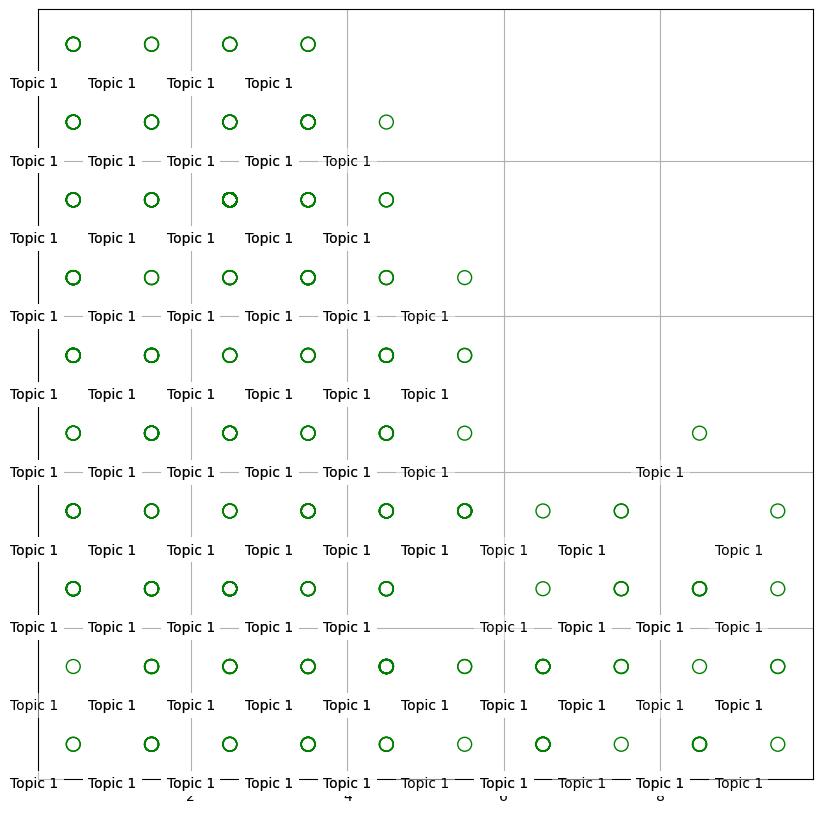

In [16]:
# Plot the SOM and label data points with LDA topics
plt.figure(figsize=(10, 10))
for i, (x, y) in enumerate(winner_neurons):
    plt.text(x, y, f'Topic {lda_model.transform(feature_matrix)[i].argmax() + 1}', ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))

plt.scatter(winner_neurons[:, 0] + 0.5, winner_neurons[:, 1] + 0.5, s=100, c='none', marker='o', edgecolor='g')
plt.grid()
plt.show()